# Using Neural Networks to Predict Credit Card Default

January 2022

Jupyter notebook created by student ID 209122352 for YSJ DSDA Artificial Intelligence Module.  This notebook analyses the Taiwan credit card default dataset.  This dataset can be found on the UCI Machine Learning repository and used throug the Creative Commons Attribution 4.0 International license.  The data has been compiled by I-Cheng Yeh.

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# Deep Learning Libraries
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, History, LearningRateScheduler
from tensorflow.keras import regularizers
from keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers 
import time
import tensorflow as tf
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from pylab import rcParams
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard

In [2]:
df = pd.read_excel("default of credit card clients.xls")
pd.set_option('display.max_columns', None)
df.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


In [3]:
keys = df.keys()
keys

Index(['Unnamed: 0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19',
       'X20', 'X21', 'X22', 'X23', 'Y'],
      dtype='object')

In [4]:
cols = df.loc[0].tolist()
print(cols)

['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month']


In [5]:
cols_dict = dict(zip(keys, cols))
df.rename(columns = cols_dict, inplace = True)
df = df.iloc[1:]
df.rename(columns = {"default payment next month": "default"}, inplace = True)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
1,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
df.rename(columns={'PAY_0': 'PAY_1'}, inplace=True)
df.drop(columns='ID',inplace=True)
df = df.apply(pd.to_numeric)

# Exploratory Data Analysis

In [7]:
# create dataframe to show null values, data type and number of unique values
df_info = pd.DataFrame(columns=['Column', 'Null', 'Dtype', 'N_Unique'])
for i in range(0, len(df.columns)):
    df_info.loc[i] = [df.columns[i],
                        df[df.columns[i]].isnull().sum(),
                        df[df.columns[i]].dtypes,
                        df[df.columns[i]].nunique()] 
    
df_info

,Column,Null,Dtype,N_Unique
0,LIMIT_BAL,0,int64,81
1,SEX,0,int64,2
2,EDUCATION,0,int64,7
3,MARRIAGE,0,int64,4
4,AGE,0,int64,56
5,PAY_1,0,int64,11
6,PAY_2,0,int64,11
7,PAY_3,0,int64,11
8,PAY_4,0,int64,11
9,PAY_5,0,int64,10


In [8]:
df.describe() # descriptive statistics for data

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## Attribute Information:

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:  

X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.  

X2: Gender (1 = male; 2 = female).  

X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).  

X4: Marital status (1 = married; 2 = single; 3 = others).  

X5: Age (year).  

X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.  

X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.  

X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

In [9]:
df['PAY_1'].value_counts()

 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_1, dtype: int64

In [10]:
# Metadata only lists four values for Education (1,2,3,4)...therefore there are three unknowns (0,5,6)
df['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [11]:
# change all unkown education values into '4' - other
df['EDUCATION']=np.where(df['EDUCATION'] == 5, 4, df['EDUCATION'])
df['EDUCATION']=np.where(df['EDUCATION'] == 6, 4, df['EDUCATION'])
df['EDUCATION']=np.where(df['EDUCATION'] == 0, 4, df['EDUCATION'])
df['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [12]:
# what is the 0 value in Marriage?
df['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [13]:
# recalibrate feature so that there are only single and married values (values = 0 & 3 will be placed into the 'single category')
df['MARRIAGE']=np.where(df['MARRIAGE'] == 0, 2, df['MARRIAGE'])
df['MARRIAGE']=np.where(df['MARRIAGE'] == 3, 2, df['MARRIAGE'])
df['MARRIAGE'].value_counts()

2    16341
1    13659
Name: MARRIAGE, dtype: int64

<AxesSubplot: xlabel='AGE', ylabel='count'>

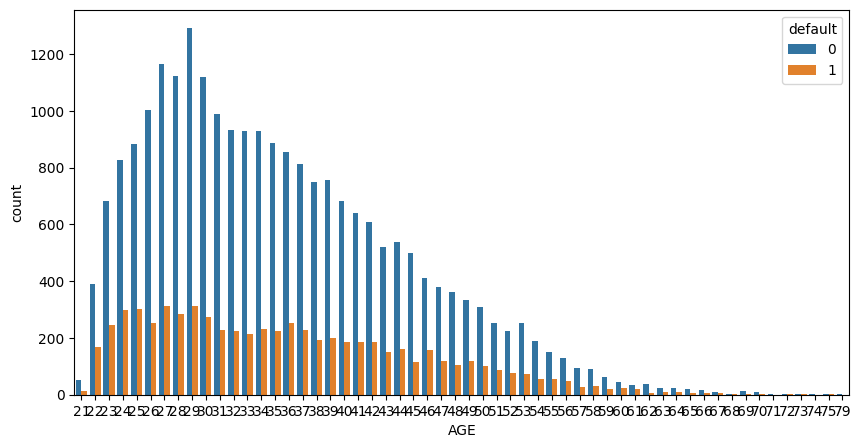

In [14]:
#df['AGE'].value_counts()
plt.figure(figsize=(10,5))
sns.countplot(x='AGE',hue='default', data=df)

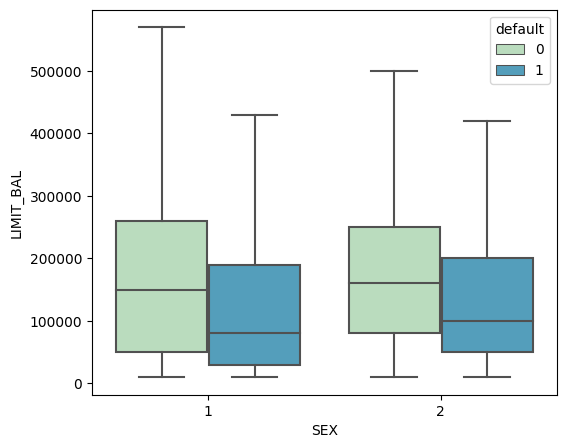

In [15]:
def box_var(ft1, ft2, ft3, width=16):
    fig, ax1 = plt.subplots(ncols=1, figsize=(width,5))
    s = sns.boxplot(ax = ax1, x=ft1, y=ft2, hue=ft3,
                data=df, palette="GnBu",showfliers=False)
    s.set_xticklabels(s.get_xticklabels())
    plt.show()
    
box_var('SEX','LIMIT_BAL', 'default',6)

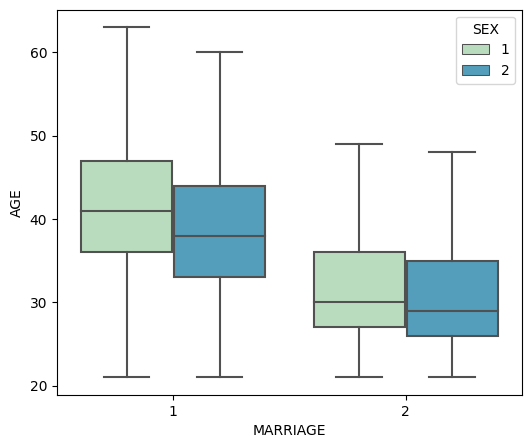

In [16]:
box_var('MARRIAGE','AGE', 'SEX',6)

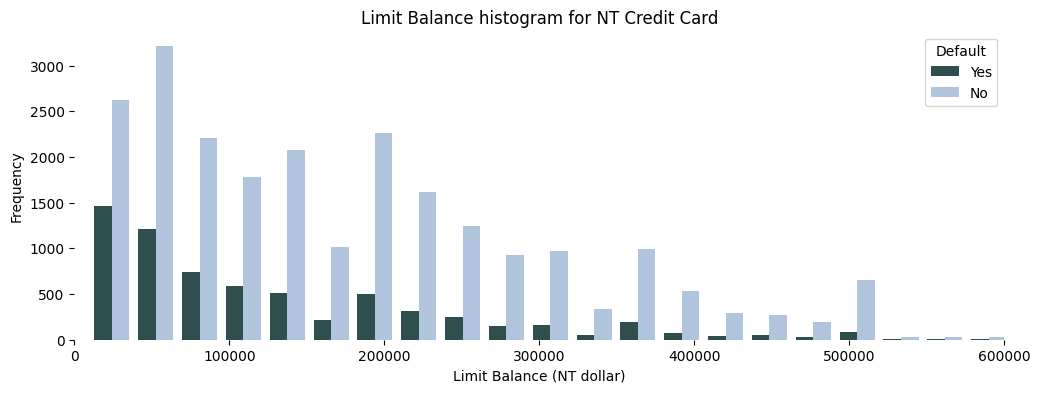

In [17]:
# historgram for balance limit with those that defaulted seperated from the non-default customers
def1 = list(df[df['default'] == 1]['LIMIT_BAL'])
def0 = list(df[df['default'] == 0]['LIMIT_BAL'])

plt.figure(figsize=(12,4))
plt.hist([def1, def0], bins = 35, color=['darkslategray', 'lightsteelblue']) 
plt.xlim([0,600000])
plt.legend(['Yes', 'No'], title = 'Default')
plt.xlabel('Limit Balance (NT dollar)')
plt.ylabel('Frequency')
plt.title('Limit Balance histogram for NT Credit Card', size=12)
plt.box(False)

<AxesSubplot: xlabel='SEX', ylabel='count'>

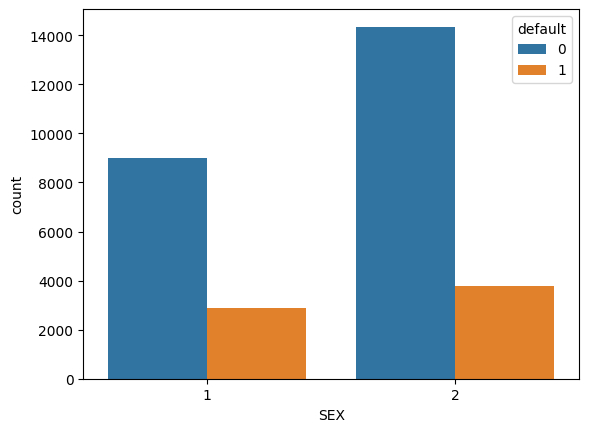

In [18]:
sns.countplot(x='SEX',hue='default', data=df)

In [19]:
#Create table to show percentage of missing values in df
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending = False)
    Percentage = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    data = pd.concat([total, Percentage], axis=1, keys=['Total', 'Percentage'])
    return data.head()
missing_data(df)

,Total,Percentage
LIMIT_BAL,0,0.0
SEX,0,0.0
PAY_AMT6,0,0.0
PAY_AMT5,0,0.0
PAY_AMT4,0,0.0


In [20]:
df['default'].value_counts()

0    23364
1     6636
Name: default, dtype: int64

<AxesSubplot: title={'center': 'Limit Balance vs Education'}, xlabel='EDUCATION', ylabel='LIMIT_BAL'>

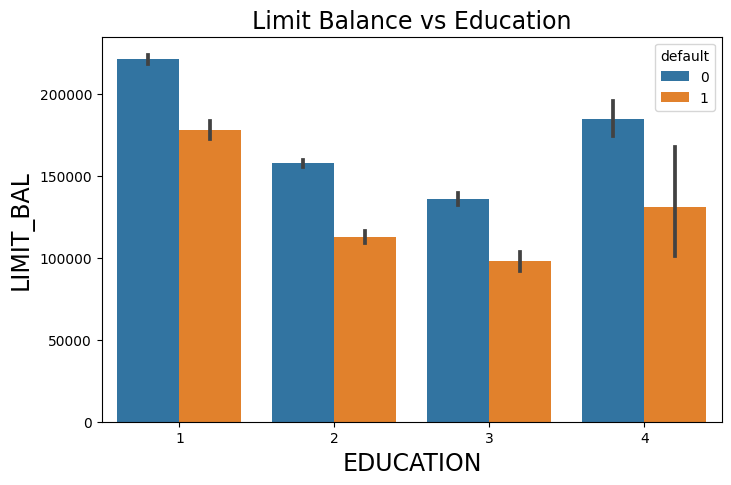

In [21]:
plt.figure(figsize=(8,5))
plt.title('Limit Balance vs Education', fontsize=17)
plt.xlabel('EDUCATION', fontsize=17)
plt.ylabel('LIMIT_BAL', fontsize=17)
sns.barplot(x='EDUCATION', y='LIMIT_BAL', data=df, hue='default')

<AxesSubplot: title={'center': 'Marriage vs Age'}, xlabel='MARRIAGE', ylabel='AGE'>

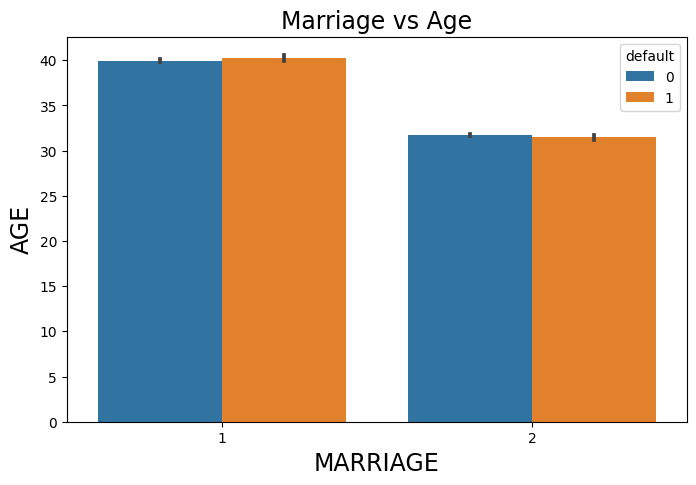

In [22]:
plt.figure(figsize=(8,5))
plt.title('Marriage vs Age', fontsize=17)
plt.xlabel('Marriage', fontsize=17)
plt.ylabel('Age', fontsize=17)
sns.barplot(x='MARRIAGE', y='AGE', data=df, hue='default')

<AxesSubplot: xlabel='MARRIAGE'>

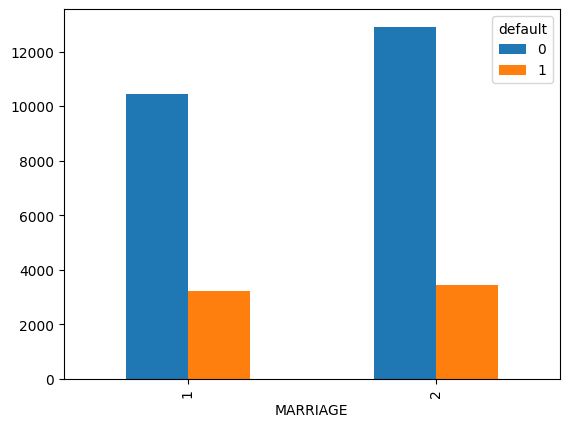

In [23]:
married=df.groupby(['MARRIAGE','default']).size().unstack(1)
married.plot(kind='bar')

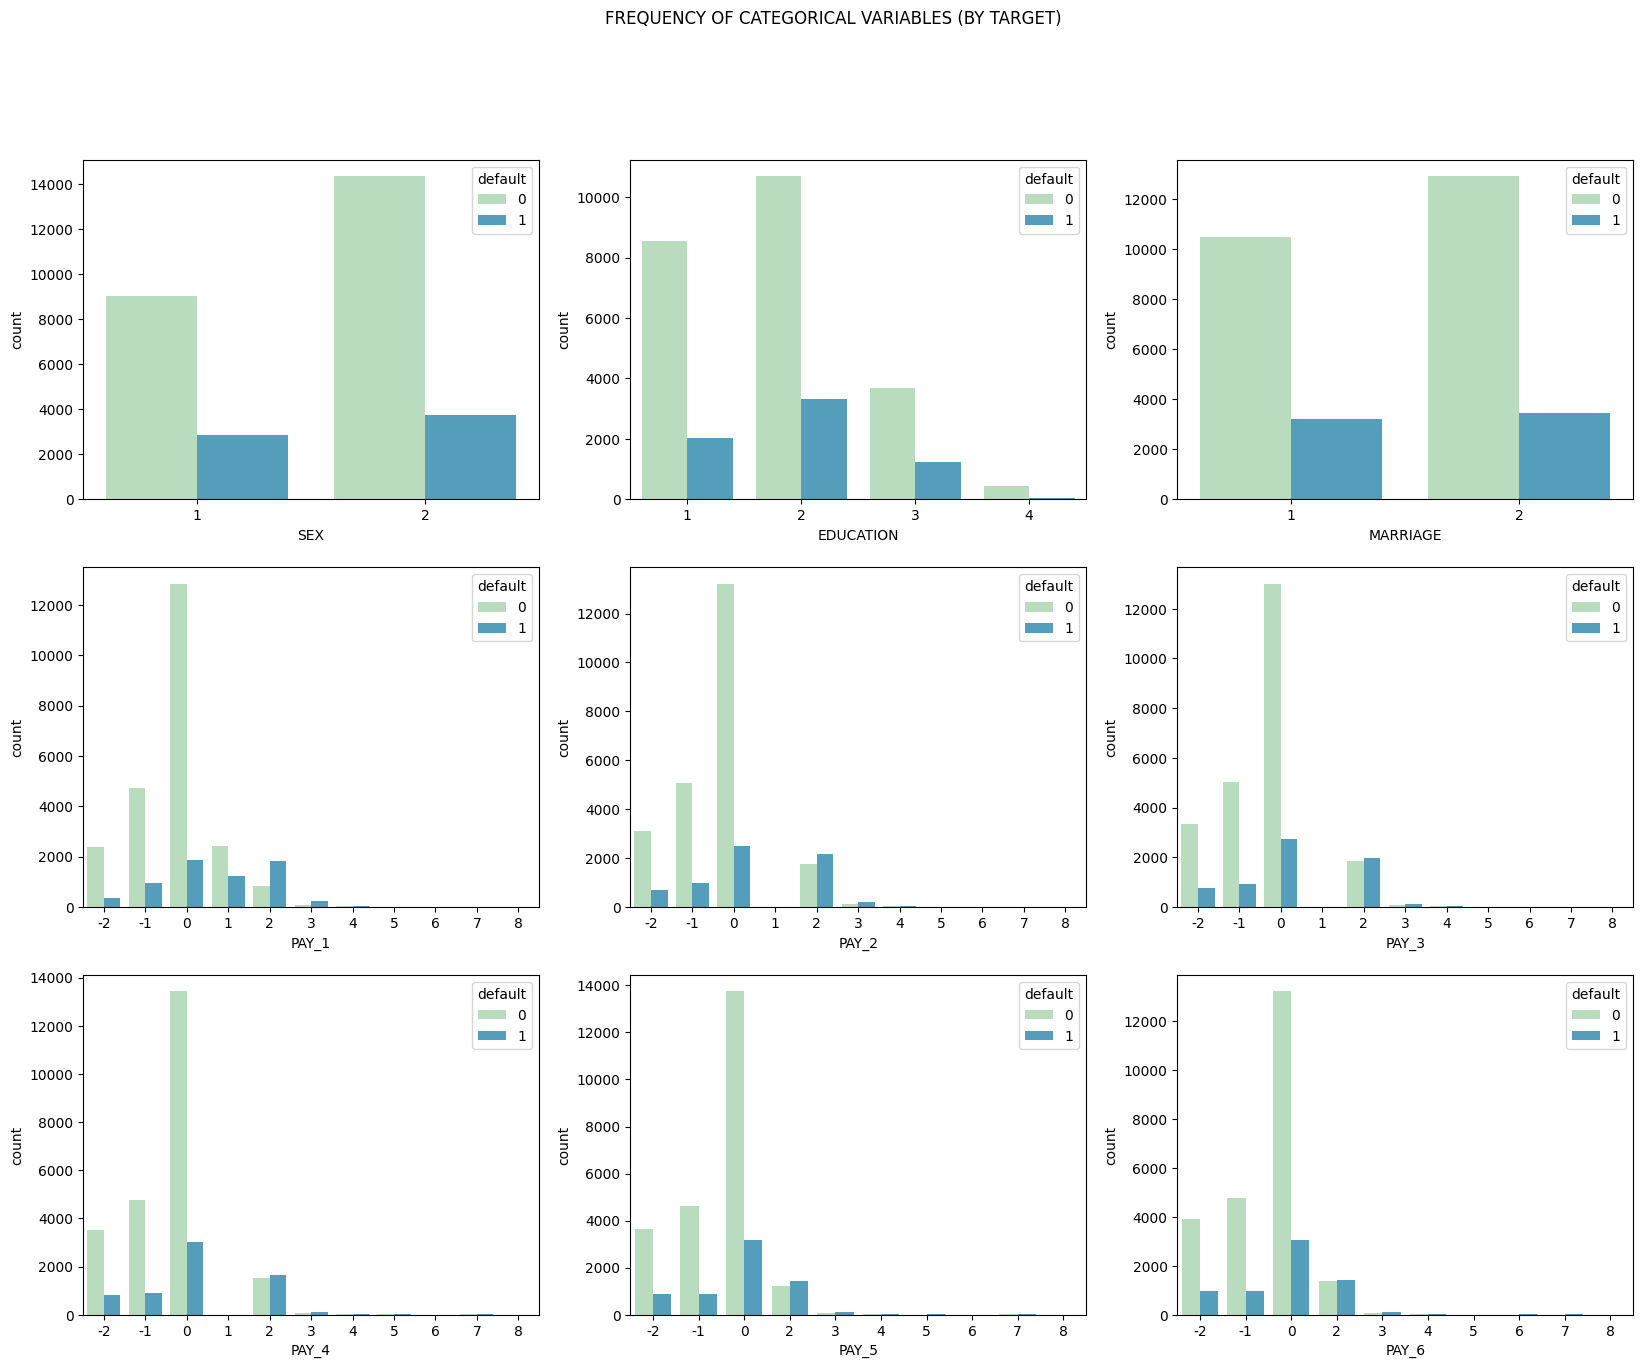

In [24]:
# Creating a new dataframe with categorical variables to run plots
subset = df[['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 
               'PAY_5', 'PAY_6', 'default']]

f, axes = plt.subplots(3, 3, figsize=(20, 15), facecolor='white')
f.suptitle('FREQUENCY OF CATEGORICAL VARIABLES (BY TARGET)')
ax1 = sns.countplot(x="SEX", hue="default", data=subset, palette="GnBu", ax=axes[0,0])
ax2 = sns.countplot(x="EDUCATION", hue="default", data=subset, palette="GnBu",ax=axes[0,1])
ax3 = sns.countplot(x="MARRIAGE", hue="default", data=subset, palette="GnBu",ax=axes[0,2])
ax4 = sns.countplot(x="PAY_1", hue="default", data=subset, palette="GnBu", ax=axes[1,0])
ax5 = sns.countplot(x="PAY_2", hue="default", data=subset, palette="GnBu", ax=axes[1,1])
ax6 = sns.countplot(x="PAY_3", hue="default", data=subset, palette="GnBu", ax=axes[1,2])
ax7 = sns.countplot(x="PAY_4", hue="default", data=subset, palette="GnBu", ax=axes[2,0])
ax8 = sns.countplot(x="PAY_5", hue="default", data=subset, palette="GnBu", ax=axes[2,1])
ax9 = sns.countplot(x="PAY_6", hue="default", data=subset, palette="GnBu", ax=axes[2,2])

<Figure size 640x480 with 0 Axes>

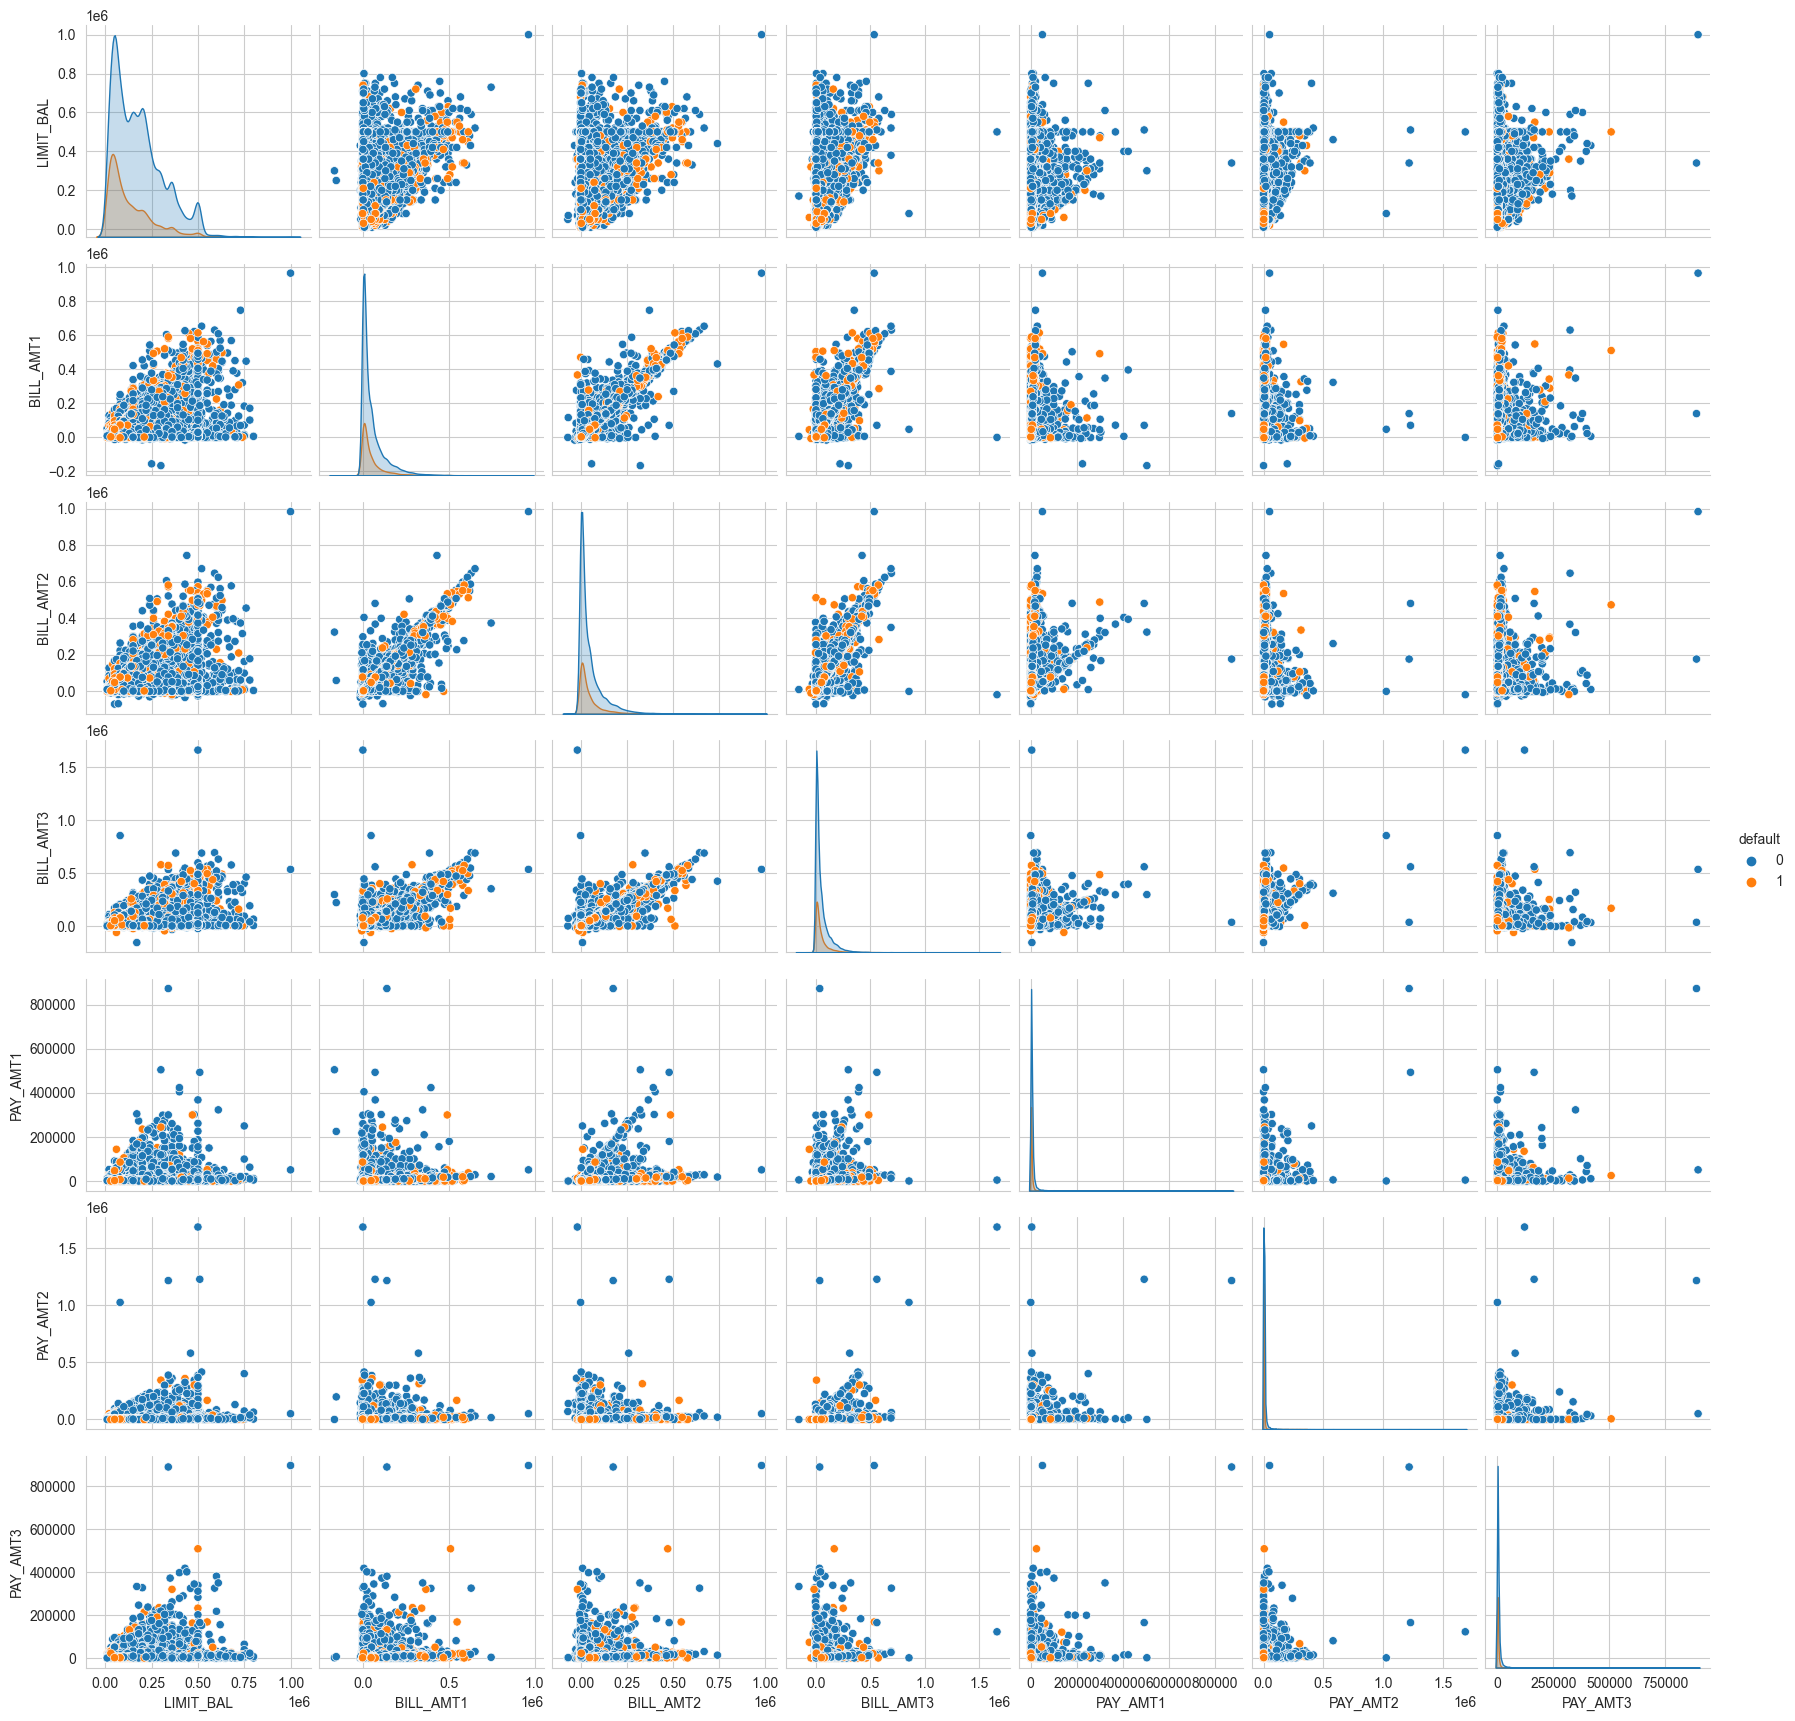

In [25]:
#plot some selected features using seaborn pairplot
sns.set_style('whitegrid')
#Plotting following features
columns = [ 'LIMIT_BAL','BILL_AMT1','BILL_AMT2','BILL_AMT3','PAY_AMT1',
           'PAY_AMT2','PAY_AMT3','default'] #'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4','PAY_5', 'PAY_6''SEX', 'EDUCATION', 'MARRIAGE'

plt.figure()
sns.pairplot(df[columns], hue= 'default')  
plt.show()

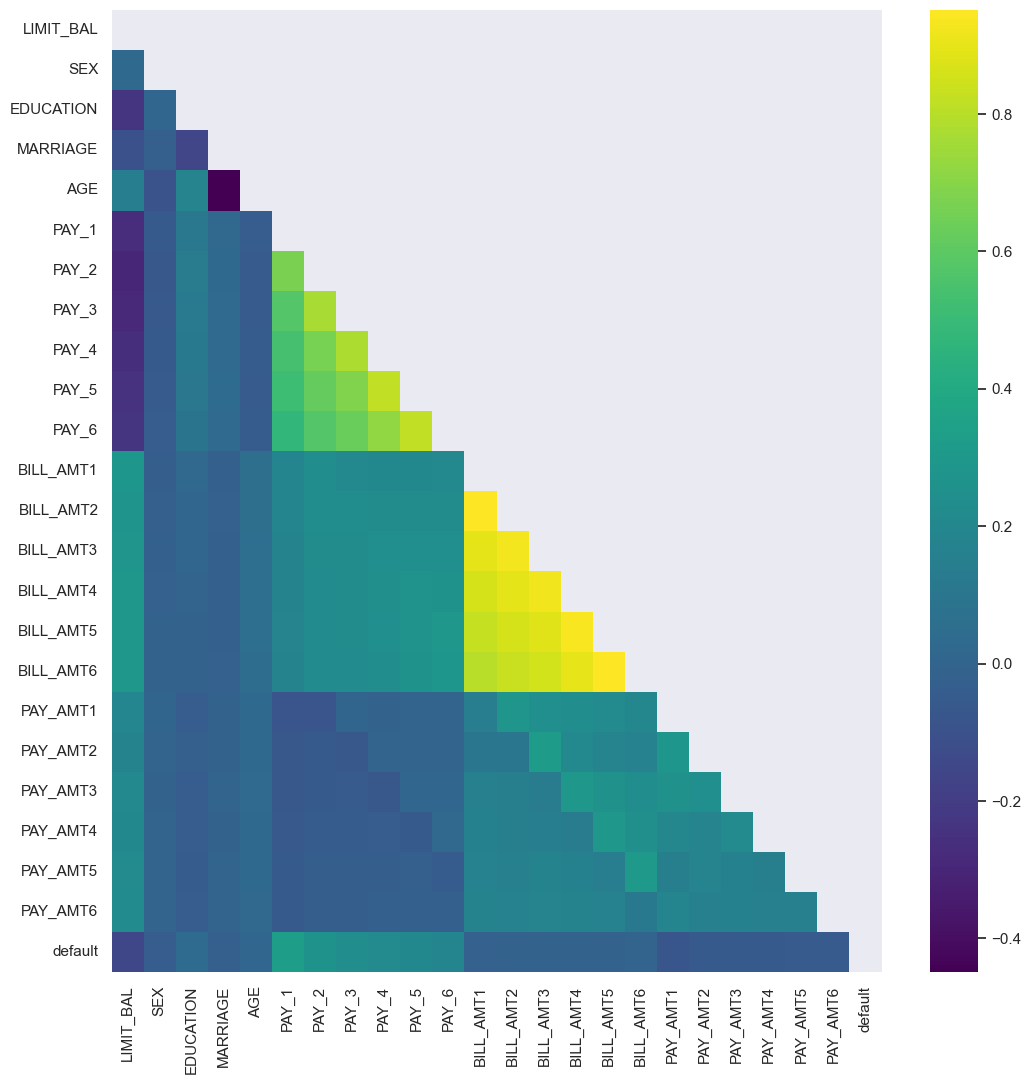

In [26]:
# Create heatmap to analyse correlation between the feature columns
sns.set(style="darkgrid")
corr=df.corr()
f, ax = plt.subplots(figsize=(11, 11))
cmap = sns.color_palette("viridis", as_cmap=True) #sns.diverging_palette(220, 10, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, cmap=cmap, ax=ax,mask=mask) #annot=True
f.tight_layout()

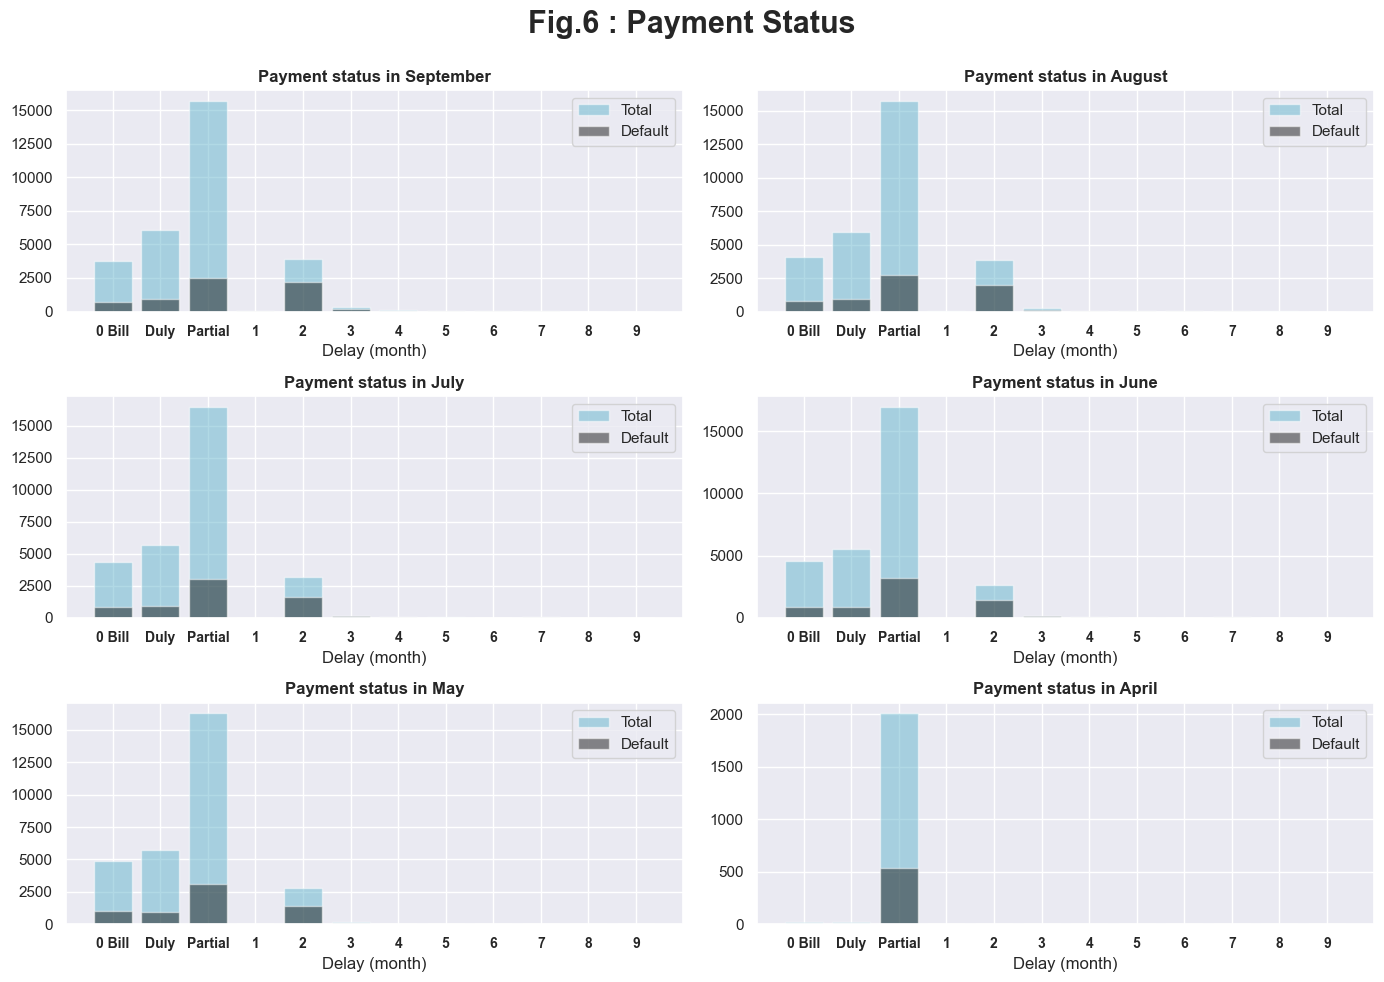

In [27]:
# Payment status (Feature name :'PAY_' )
import matplotlib.gridspec as gridspec
features = list(df.columns)
plt.figure(figsize=(14,10))
gs = gridspec.GridSpec(3,2)
i = 0

plt.suptitle('Fig.6 : Payment Status',fontweight="bold", fontsize=22)
for cn in features[6:12]:
    ax = plt.subplot(gs[i])
    delay = np.zeros(12)
    delay_default = np.zeros(12)  
    for j in np.arange(0,12):
            delay[j] = df[cn][df[cn]==j-2].count()
            delay_default[j] = df[cn][(df[cn]==j-2)&(df['default']==1)].count()  

    month = [-2,-1,0,1,2,3,4,5,6,7,8,9]
    plt.bar(month,delay, color='c',alpha=0.5, label='Total')
    plt.bar(month,delay_default, color='k',alpha=0.5, label='Default')

    plt.xticks([-2,-1,0,1,2,3,4,5,6,7,8,9],['0 Bill','Duly','Partial','1','2','3','4','5','6','7','8','9'], fontweight="bold", size=10)
    ax.set_xlabel('Delay (month)')
    months = ['September','August','July','June','May','April']
    ax.set_title('Payment status in ' + months[i], fontweight="bold", size=12)
    ax.legend()
    i+=1
    
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

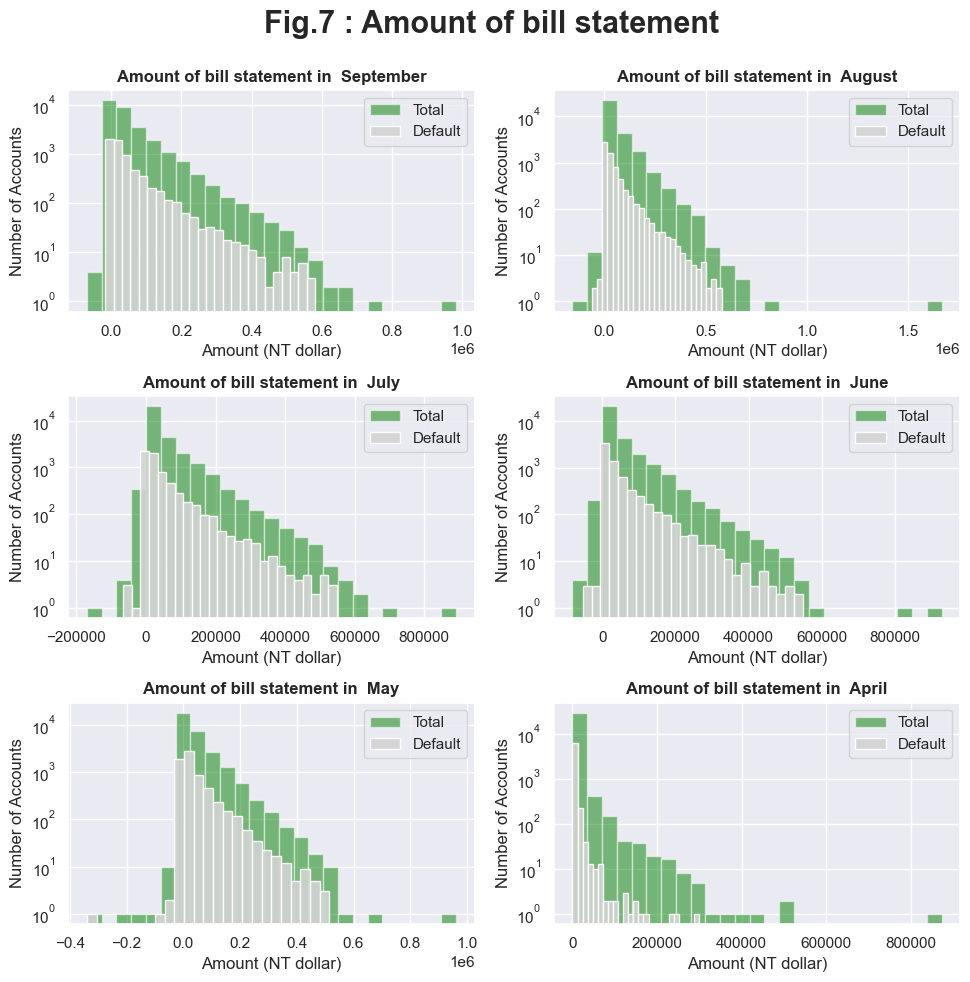

In [28]:
# Amount of bill statement (Feature name :'BILL_AMT_' )

features = list(df.columns)
plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(3,2)
i = 0
plt.suptitle('Fig.7 : Amount of bill statement',fontweight="bold", fontsize=22)
for cn in features[12:18]:
    ax = plt.subplot(gs[i])
    bins = 25
    plt.hist(df[cn],bins = bins, color='green',label = 'Total',alpha=0.5)
    plt.hist(df[cn][df['default']==1], bins = bins, color='lightgray',label = 'Default',alpha=0.9)

    plt.xlabel('Amount (NT dollar)')
    plt.ylabel('Number of Accounts')
    ax.set_yscale('log')#, nonposy='clip')

    months = ['September','August','July','June','May','April']
    ax.set_title('Amount of bill statement in  ' + months[i], fontweight="bold", size=12)
    ax.legend()
    i+=1  
    plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

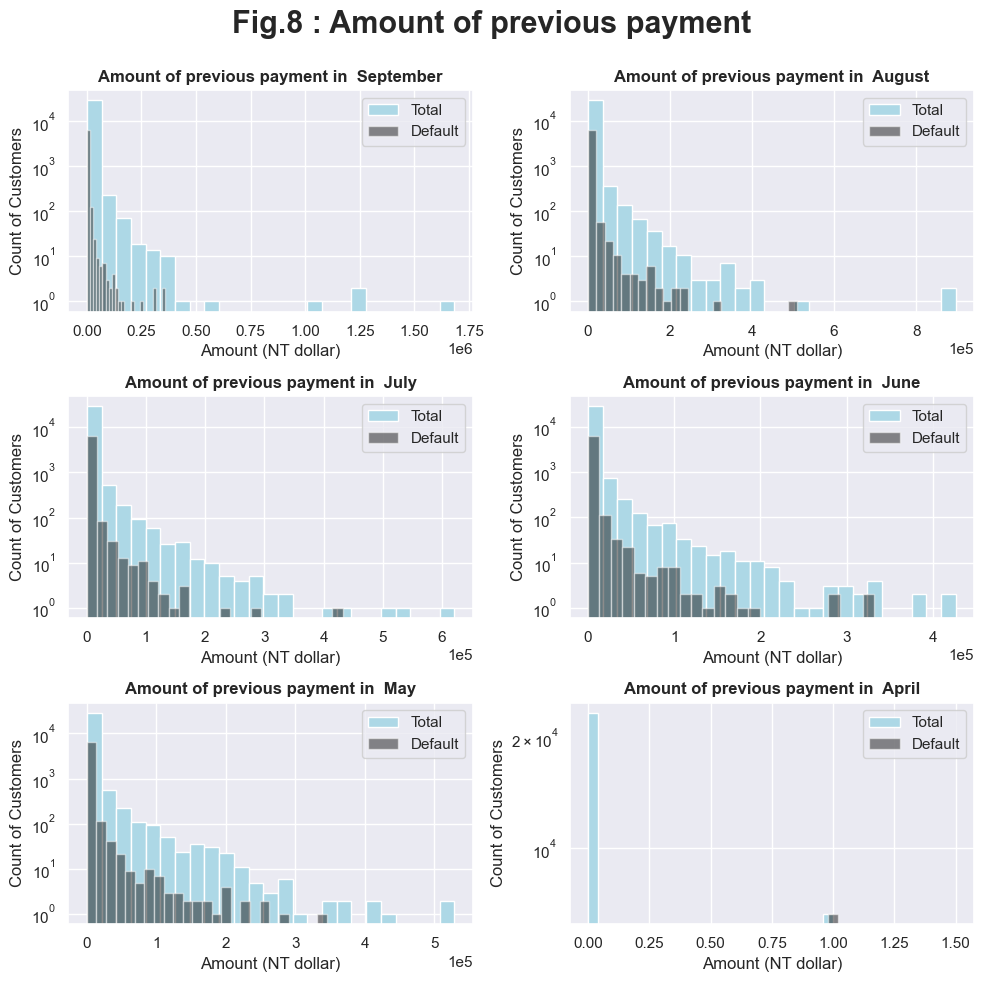

In [29]:
# Amount of previous payment (Feature name :'PAY_AMT_' )
features = list(df.columns)
plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(3,2)
i = 0
plt.suptitle('Fig.8 : Amount of previous payment',fontweight="bold", fontsize=22)
for cn in features[18:24]:
    ax = plt.subplot(gs[i])
    bins = 25
    plt.hist(df[cn],bins = bins, color='lightblue',label = 'Total',alpha=1)
    plt.hist(df[cn][df['default']==1], bins = bins, color='k',label = 'Default',alpha=0.5)

    plt.xlabel('Amount (NT dollar)')
    plt.ylabel('Count of Customers')
    ax.set_yscale('log')#, nonposy='clip')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    months = ['September','August','July','June','May','April']
    ax.set_title('Amount of previous payment in  ' + months[i], fontweight="bold", size=12)
    ax.legend()
    i+=1      
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

# Outliers

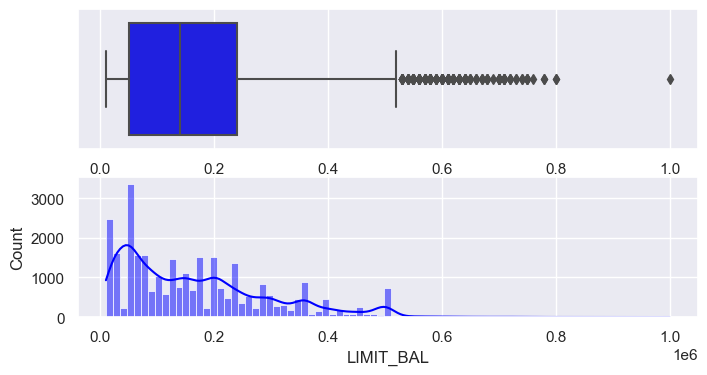

In [30]:
# plot outliers in income
fig, axes = plt.subplots(2, 1, figsize=(8,4))

sns.boxplot(data = df, x = 'LIMIT_BAL', color = 'blue', ax = axes[0])
sns.histplot(data = df, x = 'LIMIT_BAL', kde=True, color='blue', ax = axes[1])
plt.show()

In [31]:
df[df['LIMIT_BAL']>800000]

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
2198,1000000,2,1,1,47,0,0,0,-1,0,0,964511,983931,535020,891586,927171,961664,50784,50723,896040,50000,50000,50256,0


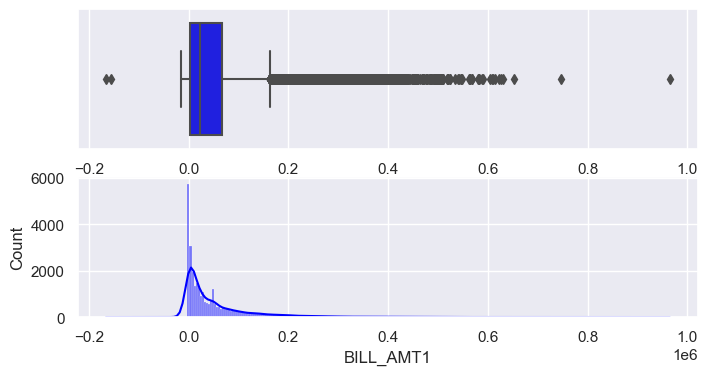

In [32]:
# plot outliers in bill amount
fig, axes = plt.subplots(2, 1, figsize=(8,4))

sns.boxplot(data = df, x = 'BILL_AMT1', color = 'blue', ax = axes[0])
sns.histplot(data = df, x = 'BILL_AMT1', kde=True, color='blue', ax = axes[1])
plt.show()

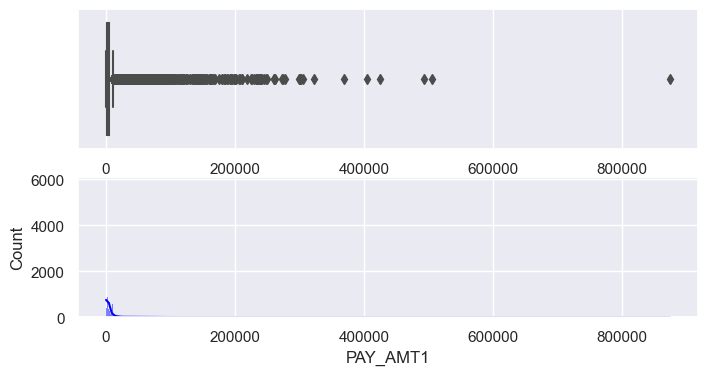

In [33]:
# plot outliers in pay amount
fig, axes = plt.subplots(2, 1, figsize=(8,4))

sns.boxplot(data = df, x = 'PAY_AMT1', color = 'blue', ax = axes[0])
sns.histplot(data = df, x = 'PAY_AMT1', kde=True, color='blue', ax = axes[1])
plt.show()

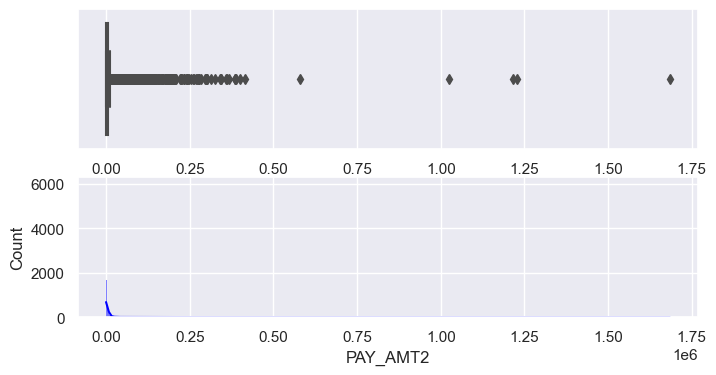

In [34]:
# plot outliers in pay amount 2
fig, axes = plt.subplots(2, 1, figsize=(8,4))

sns.boxplot(data = df, x = 'PAY_AMT2', color = 'blue', ax = axes[0])
sns.histplot(data = df, x = 'PAY_AMT2', kde=True, color='blue', ax = axes[1])
plt.show()

# Feature Engineering

In [35]:
#one hot encoding for sex, education, marriage (and pay?)  # 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'
df = pd.get_dummies(df, prefix=['FEMALE', 'EDU', 'MARRIAGE'], columns=['SEX', 'EDUCATION', 'MARRIAGE']) #drop_first=True)
df.drop(columns = ['FEMALE_1','EDU_4','MARRIAGE_2'], inplace = True) # customised version of drop_first paramater, but drops last column instead to get K-1 columns
# those values where Female_1 = 1 signify a female (0=male), Marriage_1 = 1 equals married (0=single)

In [36]:
df.rename(columns = {'FEMALE_2':'female','MARRIAGE_1':'married','EDU_1':'Grad','EDU_2':'Uni','EDU_3':'High_school'},inplace=True)

In [37]:
# create new feature to show the amount of credit consumed: cr_consume = BILL_AMT - PAY_AMT / LIMIT_BAL
for i in range(1,6):
    df['cr_consume%d' % (i)] = (df['BILL_AMT%d' % (i+1)] - df['PAY_AMT%d' % (i)]) / df['LIMIT_BAL']
    
for i in range(1,6):
    df['cr_consume6'] = df['cr_consume%d' % (i)]/6

In [38]:
df.head()

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,female,Grad,Uni,High_school,married,cr_consume1,cr_consume2,cr_consume3,cr_consume4,cr_consume5,cr_consume6
1,20000,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1,0,1,0,1,0.155100,0.000000,0.000000,0.000000,0.000000,0.000000
2,120000,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,1,0,1,0,0,0.014375,0.014017,0.018933,0.020458,0.027175,0.004529
3,90000,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,1,0,1,0,0,0.138989,0.133989,0.148122,0.154978,0.161656,0.026943
4,50000,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,1,0,1,0,1,0.924660,0.945440,0.542280,0.557180,0.569560,0.094927
5,50000,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,0,0,1,0,1,0.073400,-0.016920,0.218800,0.202920,0.368840,0.061473


## Data Processing: Normalisation

In [39]:
def normalise(data,maxi='none',mini='none'):
    feature_length=data.shape[1]
    normalised_data=np.zeros([len(data),1])
    for i in range (0,feature_length+1):
        maximum=np.amax(data[:,i-1:i], axis=0)
        minimum=np.amin(data[:,i-1:i],axis=0)
        feature=data[:,i-1:i]
        normalised_feature=(feature-minimum)/(maximum-minimum)
        normalised_data=np.concatenate((normalised_data,normalised_feature), axis=1)
    return normalised_data[:,1:]
def normalize(df):
    for col in df.columns:
        if(col == 'default'):
            continue
        else:
            if(df[col].std() > 1000): #starndard scaler
                df[col] = (df[col] - df[col].mean()) / df[col].std()
                #print("STD",col)
            else:
                df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min()) # min max scaler
                #print("MinMax",col)
    
    return df
def custom_auc(ground_truth, predictions):
    # I need only one column of predictions["0" and "1"]. You can get an error here
    # while trying to return both columns at once
    fpr, tpr, _ = roc_curve(ground_truth, predictions)    
    return auc(fpr, tpr)

In [40]:
cols_scale = ['LIMIT_BAL','AGE','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5','PAY_6','BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3','PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

### MLP data model

In [41]:
df_mlp = df.copy()
mlpX = df_mlp.drop(columns = 'default')
Y = df_mlp['default']
Y = np.array(Y)
# using standardscaler for MLP after unusable results from other normalisation techniques
mlpX[cols_scale] = preprocessing.StandardScaler().fit_transform(mlpX[cols_scale])
mlpX.sample()

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,female,Grad,Uni,High_school,married,cr_consume1,cr_consume2,cr_consume3,cr_consume4,cr_consume5,cr_consume6
2843,-0.443054,1.683111,0.014861,0.111736,0.138865,1.899436,1.999879,1.992316,-0.557921,-0.529798,-0.490858,-0.478689,-0.436679,-0.417825,-0.251378,-0.170186,-0.296801,-0.212313,-0.274864,-0.293382,1,0,1,0,1,0.090655,0.099755,0.113345,0.111482,0.121718,0.020286


In [42]:
X_train, X_test, y_train, y_test = train_test_split(mlpX, Y, test_size=0.30, random_state=42, shuffle=True)

In [43]:
X_train.shape

(21000, 31)

### Autoencoder

Autoencoder handles data slightly differently.  We input the X train data in twice but before we do that we need to seperate the X train data that is normal from that which is for the defualt data.  Thus, we will train the autoencoder on the normal data and test it on the defualt data to see what the reconstruction error is

In [44]:
ae = df.copy()
# will only scale those columns that don't already have a value between [0,1]
ae[cols_scale] = preprocessing.MinMaxScaler().fit_transform(ae[cols_scale])

X_train1, X_test1 = train_test_split(ae, test_size=0.2, random_state=42) #split data with 20% for test based on smaller dataset
X_train1 = X_train1[X_train1.default == 0] # remove those records that relate to defualt
X_train1 = X_train1.drop(['default'], axis=1) # drop defualt feature

y_test1 = X_test1['default']
X_test1 = X_test1.drop(['default'], axis=1)

X_train1 = X_train1.values
X_test1 = X_test1.values

In [45]:
X_train1.shape

(18677, 31)

### LSTM-MLP

LSTM requires additional data processing to extract the temporal features from the non-temporal and reshape them. The data was reshaped so that each record in the original dataset is represented as an array with the shape of six rows by four columns.  Each row represents a single month transaction, and each column is one of the four temporal features (repayment frequency, bill amount, payment amount and percentage of credit consumed).  The final shape of the data to be input into the model, after the train-test split, is an array of shape (21,000, 6, 4).

In [47]:
#df_cols = df.drop(columns = ['cr_consume1','cr_consume2','cr_consume3','cr_consume4','cr_consume5','cr_consume6','default']).columns
lstm = df.copy()
lstm[cols_scale] = preprocessing.StandardScaler().fit_transform(lstm[cols_scale])
# scaled_lstm = lstm[df_cols]
# unscaled_lstm = lstm[['cr_consume1','cr_consume2','cr_consume3','cr_consume4','cr_consume5','cr_consume6','default']]
# scaled_lstm = normalize(scaled_lstm)
# df_lstm = pd.concat([scaled_lstm,unscaled_lstm], axis=1)
lstm.sample()

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,female,Grad,Uni,High_school,married,cr_consume1,cr_consume2,cr_consume3,cr_consume4,cr_consume5,cr_consume6
8088,0.327685,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,0.463147,0.506992,0.023531,0.117563,0.19795,0.25099,-0.191003,-0.126784,-0.126411,-0.14848,-0.150503,-0.180878,0,0,0,1,0,1,0.39411,0.217357,0.227743,0.237362,0.244376,0.040729


In [49]:
df_nontemp = lstm[['LIMIT_BAL','AGE','female','Grad','Uni','High_school','married']]

In [50]:
df_x = lstm.drop(columns=['default'])
df_y = lstm['default'].values
X_train_lstm_, X_test_lstm_, y_train_lstm_, y_test_lstm_ = train_test_split(df_x, df_y, test_size=0.30, random_state=42)

In [51]:
def organize_temporal_feat(df1,df2):
    """
    Engineer temporal features for feeding into LSTM model.  Will return dataframe with four columns, one for
    each of the temporal featuers.
    """
    
    features = ['PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                        'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
                        'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
                        'cr_consume1','cr_consume2','cr_consume3','cr_consume4','cr_consume5','cr_consume6'] #'default'
    
    df1 = df1[features]
    df1 = df1[features]
    train = []
    test = []
    
    for row in range(len(df1)):
        
        feat_1 = df1.iloc[row,0:6] # extract 6 'PAY' features
        feat_2 = df1.iloc[row,6:12] # extract 6 'BILL_AMT' features
        feat_3 = df1.iloc[row,12:18] # extract 6 'PAY_AMT' features
        feat_4 = df1.iloc[row,18:24] # extract 6 'cr_consume features
        
        feat_1 = np.array(feat_1) # turn into array and reshape from row vector to column vector
        feat_1 = feat_1.reshape(-1,1) #transpose features to be concatenated and then run through with a timestep
        feat_2 = np.array(feat_2)
        feat_2 = feat_2.reshape(-1,1)
        feat_3 = np.array(feat_3)
        feat_3 = feat_3.reshape(-1,1)
        feat_4 = np.array(feat_4)
        feat_4 = feat_4.reshape(-1,1)
        
        record = np.concatenate((feat_1,feat_2,feat_3,feat_4), axis=1) #concatenate temporal features 

        df_record = pd.DataFrame(data=record, columns=['PAY','BILL_AMT','PAY_AMT','cr_consume'])        
        train.append(df_record)
        
    for row in range(len(df2)):
        
        feat_1 = df2.iloc[row,0:6] # extract 6 'PAY' features
        feat_2 = df2.iloc[row,6:12] # extract 6 'BILL_AMT' features
        feat_3 = df2.iloc[row,12:18] # extract 6 'PAY_AMT' features
        feat_4 = df2.iloc[row,18:24] # extract 6 'cr_consume features'
        #feat_label = df.iloc[row,len(features)-1] #Y / label
        
        feat_1 = np.array(feat_1) # turn into array and reshape from row vector to column vector
        feat_1 = feat_1.reshape(-1,1) #transpose features to be concatenated and then run through with a timestep
        feat_2 = np.array(feat_2)
        feat_2 = feat_2.reshape(-1,1)
        feat_3 = np.array(feat_3)
        feat_3 = feat_3.reshape(-1,1)
        feat_4 = np.array(feat_4)
        feat_4 = feat_4.reshape(-1,1)
        
        record = np.concatenate((feat_1,feat_2,feat_3,feat_4), axis=1) #concatenate temporal features 

        df_record2 = pd.DataFrame(data=record, columns=['PAY','BILL_AMT','PAY_AMT','cr_consume'])
        
        test.append(df_record2)
    return train,test

In [52]:
X_train_lstm, X_test_lstm = organize_temporal_feat(X_train_lstm_,X_test_lstm_)

In [53]:
def get_lstm_train_test(temp_X_train, temp_Y_train):
    """Function to divide up the x features and target feature and return each record as an array with six
    rows and four columns"""
    x_lstm = []
    y_lstm = []

    col_len = 4 # number of temporal features
    
    for num in range(len(temp_X_train)): #range(0, 21000)
        
        x_lstm.append(temp_X_train[num].iloc[0:(len(temp_X_train[num])),0:(col_len)].values)
    
    for num in range(len(temp_Y_train)):
        y_lstm.append(temp_Y_train[num].iloc[0:(len(temp_Y_train[num])),0:(col_len)].values)
    
    x_lstm = np.array(x_lstm)
    # will produce array of (24,1) - all six timesteps with four columns each
    y_lstm = np.array(y_lstm)
    
    print(x_lstm.shape, y_lstm.shape)
        
    return x_lstm, y_lstm

In [54]:
x_lstm_train,x_lstm_test = get_lstm_train_test(X_train_lstm,X_test_lstm)

(21000, 6, 4) (9000, 6, 4)


In [55]:
x_mlp_train = X_train_lstm_[['LIMIT_BAL','AGE','female','Grad','Uni','High_school','married']].values
x_mlp_test = X_test_lstm_[['LIMIT_BAL','AGE','female','Grad','Uni','High_school','married']].values

In [56]:
x_mlp_train.shape

(21000, 7)

# Parameter Optimisation using Grid Search and Model Build

### MLP

In [57]:
my_auc = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)
def build_mlnn(activation1 = 'relu',
              activation_final_layer = 'sigmoid',
              kernel_initializer="glorot_uniform",  
              optimizer = 'Adam',
              loss='BinaryCrossentropy',
              #optimizer='Adamax',
              learning_rate=0.01,              
              metrics='AUC',
              dropout_rate = 0.2,              
              hidden_dim=31,
              input_dim=31,
              num_classes=1):
      
    model = Sequential()
    model.add(Dense(hidden_dim, input_dim=input_dim, activation=activation1, use_bias=False, kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_dim, activation=activation1, use_bias=False))
    model.add(Dense(units=num_classes, activation=activation_final_layer))
       
    #optimizer=optimizer(lr=learning_rate)     
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=optimizer,
                  metrics=[metrics]) 
    print(model.summary())
    return model

param_grid = {
              'epochs':[50,100,250],#[200,250,300,350,400,450,500,550,600,750,800,900,1000.1200,1400,1600],
              'batch_size':[32,128,256],#[8,16,32,64,128,256,512],
              #'epochs' :              [100,150,200],
              #'batch_size' :          [32, 128],
              #'optimizer' :           ['Adam', 'Nadam'],
              #'dropout_rate' :        [0.2, 0.3],
              'activation1' :          ['relu','tanh'],# 'elu']
              #'activation1':['relu','softmax'],#'tanh',,'selu','elu','exponential','gelu','get','hard_sigmoid','serialize','softplus','softsign','swish'],
              'activation_final_layer':['sigmoid'], #'hard_sigmoid'
              #'kernel_initializer':["glorot_uniform"],#"he_normal","he_uniform","lecun_uniform","lecun_normal","random_uniform","random_normal","zeros","ones"],  
              'optimizer' : ['Adam'],#, 'Adamax'],
              'loss':['BinaryCrossentropy'],
              #'optimizer':['Adamax','Adam','SGD','Adadelta','Nadam','RMSprop','Ftrl','Adagrad'],
              'learning_rate':[0.01,0.001],#[0.00001, 0.0001],              
              'metrics':['AUC'],
              'dropout_rate':[0.01,0.05],              
              'hidden_dim':[8,32,64],#[8,16,32,64,128,256,512,1024,2048,4096],
              'input_dim':[31],
              'num_classes':[1]
             } 
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=3, scoring_fit='roc_auc',
                       do_probabilities = False):
    gs = sklearn.model_selection.GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=5, 
        scoring=scoring_fit,
        verbose=3
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred       
model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn = build_mlnn, verbose=3)

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                        param_grid, cv=3, scoring_fit=my_auc) 

print(model.best_score_)
print(model.best_params_)

C:\Users\CGSIAHA\AppData\Local\Temp\ipykernel_10556\2342078408.py:68: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn = build_mlnn, verbose=3)


Fitting 3 folds for each of 108 candidates, totalling 324 fits


C:\Users\CGSIAHA\Anaconda3\envs\LSTM_RNN\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                992       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1024      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                1024      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,113
Trainable params: 2,113
Non-trainable params: 0
_________________________________________________________________


C:\Users\CGSIAHA\Anaconda3\envs\LSTM_RNN\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None
Epoch 1/100
83/83 [==============================] - 2s 5ms/step - loss: 3.4698 - auc: 0.6239 - accuracy: 0.7528 - precision: 0.3866
Epoch 2/100
83/83 [==============================] - 0s 5ms/step - loss: 1.9651 - auc: 0.6980 - accuracy: 0.7830 - precision: 0.7315
Epoch 3/100
83/83 [==============================] - 0s 6ms/step - loss: 1.0785 - auc: 0.7040 - accuracy: 0.7787 - precision: 0.7101
Epoch 4/100
83/83 [==============================] - 1s 7ms/step - loss: 0.6511 - auc: 0.7039 - accuracy: 0.7773 - precision: 0.0000e+00
Epoch 5/100
83/83 [==============================] - 1s 10ms/step - loss: 0.5361 - auc: 0.7057 - accuracy: 0.7773 - precision: 0.0000e+00
Epoch 6/100
83/83 [==============================] - 1s 6ms/step - loss: 0.5210 - auc: 0.7072 - accuracy: 0.7793 - precision: 0.7733
Epoch 7/100
83/83 [==============================] - 0s 6ms/step - loss: 0.5166 - auc: 0.7132 - accuracy: 0.7856 - precision: 0.7479
Epoch 8/100
83/83 [==============================] - 1s

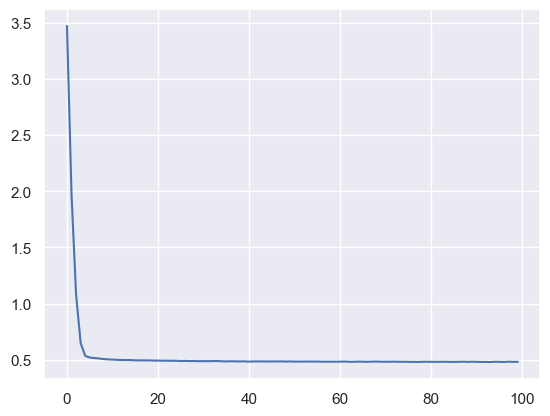

282/282 [==============================] - 1s 3ms/step
Test AUC (from sklearn): 0.6321254638218925
Test loss: 0.4771963357925415
Test AUC (from tf): 0.7156845927238464
Test accuracy: 0.8169999718666077
Test precision: 0.6776390671730042
dict_keys(['loss', 'auc', 'accuracy', 'precision'])


In [58]:
#Neural Network Hyperparameters

input_dim = X_train.shape[1]
num_classes = 1
num_epochs = 100 #50
layer_dim = 1
learning_rate = 0.001
batch_size = 256   #128 #int(opt)32
dropout= 0.05 
hidden_dim= 32  #512
output_activation = 'sigmoid'
initial_activation = 'tanh'#'relu'
kernel_initializer="glorot_uniform"
bias_initializer="glorot_uniform"
loss_function=tf.keras.losses.BinaryCrossentropy()
optimiser=optimizers.Adam(lr=learning_rate)
metric1=tf.keras.metrics.AUC()
metric2= tf.keras.metrics.Accuracy()
metric3= tf.keras.metrics.Precision()
kernel_regularizer='l1_l2'# 'l2','l1_l2'

##Building the MLP
        
history = History()
model = Sequential()
model.add(Dense(hidden_dim, input_dim=input_dim, activation=initial_activation, use_bias=True, bias_initializer=bias_initializer, kernel_initializer=kernel_initializer,kernel_regularizer=kernel_regularizer))
model.add(Dropout(dropout))
model.add(Dense(hidden_dim, activation=initial_activation, use_bias=True, bias_initializer=bias_initializer, kernel_initializer=kernel_initializer,kernel_regularizer=kernel_regularizer))
model.add(Dense(units=num_classes, activation=output_activation))
   
#sgd=optimizers.Adamax(lr=learning_rate)     
model.compile(loss=loss_function,
              optimizer=optimiser,
              metrics=['AUC','accuracy','Precision']) #[metric1,metric2, metric3]
print(model.summary())
model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, callbacks=[history])
plt.plot(history.history['loss'], label='train')
plt.show()

#Model Evaluation
score =(loss, AUC, accuracy, precision) = model.evaluate(X_test, y_test, verbose=1)
y_pred=model.predict(X_test)
y_pred[y_pred <= 0.5] = 0. #set prediction values to 0 and 1
y_pred[y_pred > 0.5] = 1.
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_ = auc(fpr, tpr)
print('Test AUC (from sklearn):',custom_auc(y_test, y_pred))
print('Test loss:',score[0])
print('Test AUC (from tf):',score[1])
print('Test accuracy:',score[2])
print('Test precision:',score[3])
#print('Test f1-score:',score[4])
#print('Test recall:',score[5])
print(history.history.keys())

<function matplotlib.pyplot.show(close=None, block=None)>

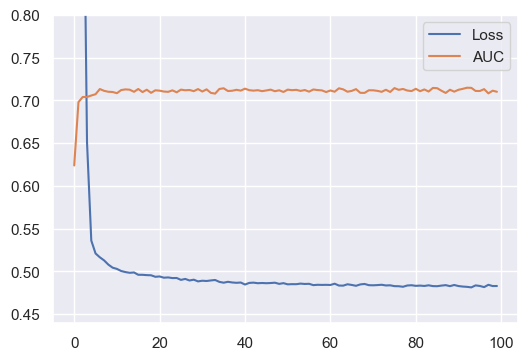

In [59]:
fig =  plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['auc'], label='train')
plt.legend(labels = ['Loss', 'AUC']) #'Accuracy'
plt.ylim(0.44,0.8)
plt.show

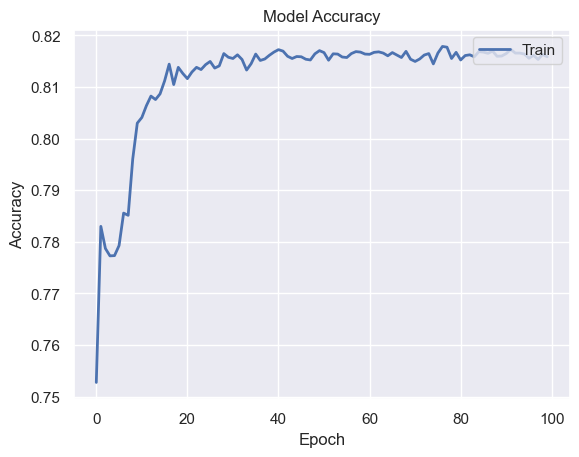

In [60]:
# Model Accuracy
plt.plot(history.history['accuracy'], linewidth=2, label='Train')
#plt.plot(history.history['val_accuracy'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

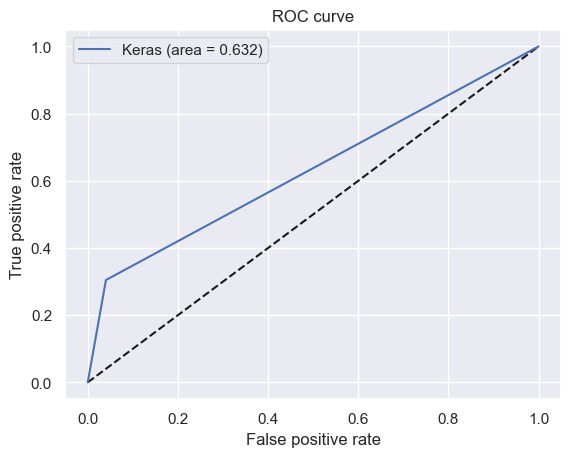

In [61]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(custom_auc(y_test, y_pred)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [62]:
print(min(y_pred),max(y_pred), np.mean(y_pred))

[0.] [1.] 0.09788889


              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7040
           1       0.68      0.30      0.42      1960

    accuracy                           0.82      9000
   macro avg       0.75      0.63      0.66      9000
weighted avg       0.80      0.82      0.79      9000



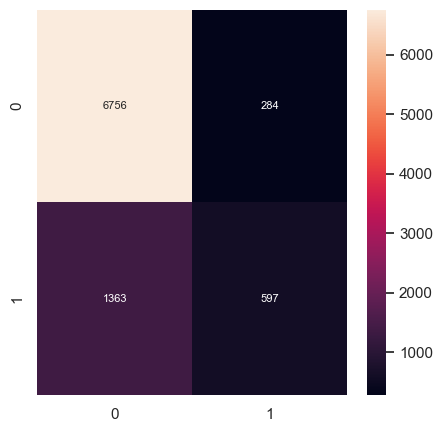

In [63]:
from sklearn.metrics import classification_report, confusion_matrix
#Confusion Matrix
ypred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (5,5))

sns.heatmap(cm, annot=True, annot_kws={"size": 8}, fmt='g') # font size
plt.show()

### LSTM-MLP

In [ ]:
my_auc = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)
def build_lstm(activation1 = 'tanh',#'relu',
              activation_final_layer = 'relu',
              kernel_initializer="glorot_uniform",
              recurrent_activation='sigmoid',#
              recurrent_initializer="orthogonal",
              optimizer = 'Adam',
              loss='BinaryCrossentropy',
              learning_rate=0.001,              
              metrics='AUC',
              dropout_rate = 0.05,              
              hidden_dim=4,
              input_dim=4,
              num_classes=1):
      
    model = Sequential()
    model.add(LSTM(hidden_dim, input_shape=(6,4), activation=activation1, use_bias=False, recurrent_activation=recurrent_activation,recurrent_initializer=recurrent_initializer,  recurrent_dropout=dropout_rate,kernel_initializer=kernel_initializer, return_sequences = True))
    model.add(Bidirectional(LSTM(hidden_dim, input_shape=(6,4), activation=activation1, use_bias=False, recurrent_activation=recurrent_activation,recurrent_initializer=recurrent_initializer,  recurrent_dropout=dropout_rate,kernel_initializer=kernel_initializer, return_sequences = False)))
    
    model.add(Dense(units=num_classes, activation=activation_final_layer))
     
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=optimizer,
                  metrics=[metrics]) 
    print(model.summary())
    return model

param_grid = {
              'epochs':[10],#[200,250,300,350,400,450,500,550,600,750,800,900,1000.1200,1400,1600],
              'batch_size':[1],#[8,16,32,64,128,256,512],
              #'epochs' :              [100,150,200],
              #'batch_size' :          [32, 128],
              #'optimizer' :           ['Adam', 'Nadam'],
              #'dropout_rate' :        [0.2, 0.3],
              'activation1' :          ['relu','tanh'],# 'elu']
              #'activation1':['relu','softmax'],#'tanh',,'selu','elu','exponential','gelu','get','hard_sigmoid','serialize','softplus','softsign','swish'],
              'activation_final_layer':['sigmoid','relu'], #'hard_sigmoid'
              #'kernel_initializer':["glorot_uniform"],#"he_normal","he_uniform","lecun_uniform","lecun_normal","random_uniform","random_normal","zeros","ones"],  
              'optimizer' : ['Adam'], #, 'Adamax'
              'loss':['BinaryCrossentropy'],
              #'optimizer':['Adamax','Adam','SGD','Adadelta','Nadam','RMSprop','Ftrl','Adagrad'],
              'learning_rate':[0.01,0.001],#[0.00001, 0.0001],              
              'metrics':['AUC'],
              'dropout_rate':[0.05], #0.1,             
              'hidden_dim':[4,8,32],#[8,16,32,64,128,256,512,1024,2048,4096],
              'input_dim':[4],
              'num_classes':[1]
             } 
def algorithm_pipeline(x_lstm_train, x_lstm_test, y_train, y_test, 
                       model, param_grid, cv=3, scoring_fit='roc_auc',
                       do_probabilities = False):
    gs = sklearn.model_selection.GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=5, 
        scoring=scoring_fit,
        verbose=3
    )
    fitted_model = gs.fit(x_lstm_train, y_train)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(x_lstm_test)
    else:
        pred = fitted_model.predict(x_lstm_test)
    
    return fitted_model, pred       
model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn = build_lstm, verbose=3)

model, pred = algorithm_pipeline(x_lstm_train, x_lstm_test, y_train, y_test, model, 
                                        param_grid, cv=2, scoring_fit=my_auc) 

print(model.best_score_)
print(model.best_params_)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 6, 4)]       0           []                               
                                                                                                  
 lstm_6 (LSTM)                  (None, 6, 8)         416         ['input_13[0][0]']               
                                                                                                  
 lstm_7 (LSTM)                  (None, 8)            544         ['lstm_6[0][0]']                 
                                                                                                  
 dense_36 (Dense)               (None, 1)            9           ['lstm_7[0][0]']                 
                                                                                            

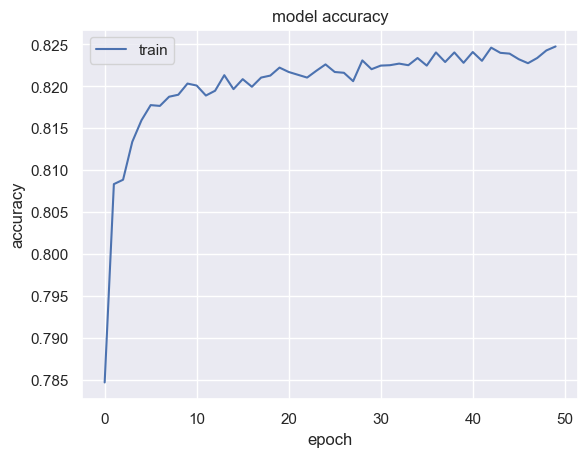

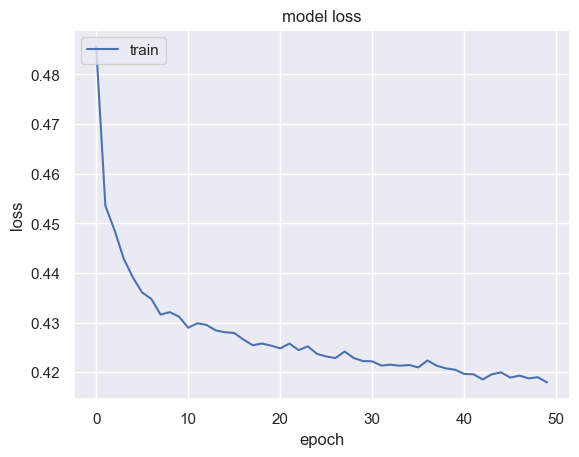

282/282 [==============================] - 1s 2ms/step


In [180]:
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model
from keras.utils import plot_model
num_epochs = 50
learning_rate = 0.001
loss_function=tf.keras.losses.BinaryCrossentropy()
optimiser=optimizers.Adam(learning_rate=learning_rate)
metric1=tf.keras.metrics.AUC()
metric2= tf.keras.metrics.Accuracy()
metric3= tf.keras.metrics.Precision()


#lstm input shape
lstm_input = Input(shape=x_lstm_train.shape[1:]) # instantiates keras tensor
#lstm units # keeping default settings mostly
hidden1 = LSTM(8,activation='tanh',  # 'tanh', relu
    recurrent_activation='tanh', #sigmoid
    use_bias=True,
    # dropout = 0.05       
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros',return_sequences=True,)(lstm_input)

hidden2 = LSTM(8,activation='tanh',return_sequences=False)(hidden1) # relu
#hidden3 = Dense(32, activation='tanh')(hidden2) #'sigmoid'
#lstm output which will be predicted 
lstm_output = Dense(1, activation='sigmoid')(hidden2)
#mlp input with additonal 7 variables 
mlp_input=Input(shape=(x_mlp_train.shape[1])) 
#combine the lstm output which is predicted var1 at t=t and key in var2,var3,var4 at t=t
x = Concatenate()([lstm_output, mlp_input])

hidden4 = Dense(64, activation='sigmoid')(x) #'relu'
#mlp model output which is predicted var1 at t=t
mlp_out = Dense(1, activation='sigmoid')(hidden4) #'linear',relu
#final output of combined model which is predicted var1 at t=t
model = Model(inputs=[lstm_input, mlp_input],outputs=mlp_out)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)
#compile the model
#model.compile(loss='mae', optimizer='adam')
model.compile(loss=loss_function,
              optimizer=optimiser,
              metrics=[metric1,'accuracy', metric3])
# summarize layers
print(model.summary())
history = History()
# plot graph
plot_model(model)#, to_file='shared_input_layer.png')
#fit the model
history = model.fit([x_lstm_train, x_mlp_train], y_train, batch_size=1, 
                    epochs=num_epochs,callbacks=[callback, history])#,validation_split=0.2) # 
print("\n\n",history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# plt.plot(history.history['loss'], label='train')
# plt.show()

#Model Evaluation
#score =(loss, AUC, accuracy, precision) = model.evaluate(x_lstm_test, y_test, verbose=1)
y_predlstm = model.predict([x_lstm_test,x_mlp_test])
y_predlstm[y_predlstm <= 0.5] = 0.
y_predlstm[y_predlstm > 0.5] = 1.
#y_test = y_test.reshape((len(y_test),-1))
fpr, tpr, thresholds = roc_curve(y_test, y_predlstm)
auc_ = auc(fpr, tpr)

<function matplotlib.pyplot.show(close=None, block=None)>

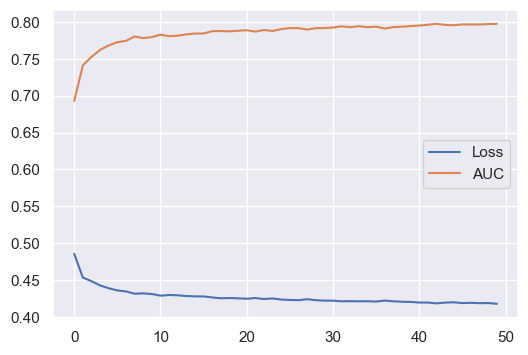

In [181]:
fig =  plt.figure(figsize=(6,4))
#plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['auc_5'], label='train')
plt.legend(labels = ['Loss', 'AUC']) #'Accuracy'
plt.show

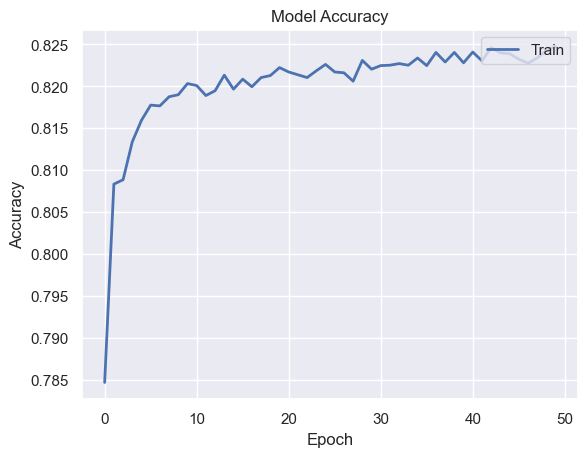

In [182]:
# Model Accuracy
plt.plot(history.history['accuracy'], linewidth=2, label='Train')
#plt.plot(history.history['val_accuracy'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

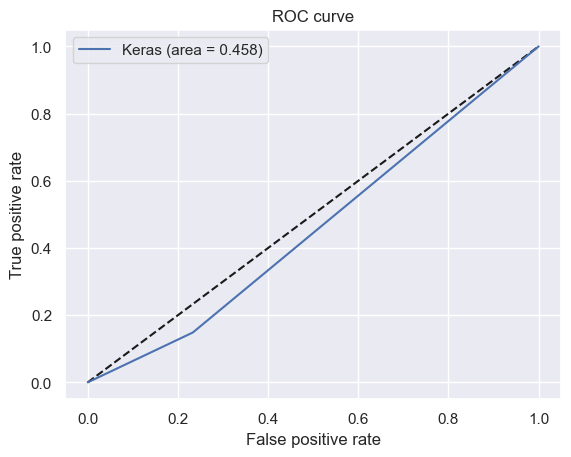

In [183]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_))#.format(custom_auc(y_test, y_pred)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

              precision    recall  f1-score   support

           0       0.76      0.77      0.77      7040
           1       0.15      0.15      0.15      1960

    accuracy                           0.63      9000
   macro avg       0.46      0.46      0.46      9000
weighted avg       0.63      0.63      0.63      9000



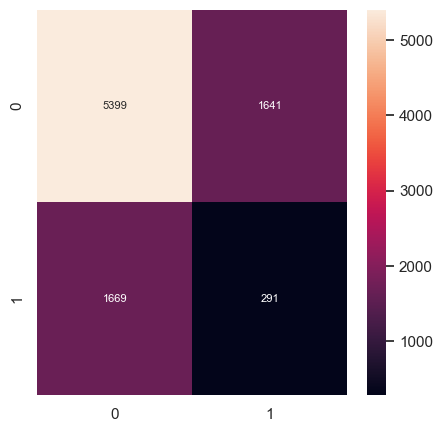

In [184]:
from sklearn.metrics import classification_report, confusion_matrix
#Confusion Matrix
ypred = np.argmax(y_predlstm, axis=1)

print(classification_report(y_test, y_predlstm))
cm = confusion_matrix(y_test, y_predlstm)
cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (5,5))

sns.heatmap(cm, annot=True, annot_kws={"size": 8}, fmt='g') # font size
plt.show()

### Autoencoder

In [ ]:
my_auc = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)
def build_ae(activation1 = 'tanh',
              activation_final_layer = 'sigmoid',
              #kernel_initializer="glorot_uniform",  
              optimizer = 'Adam',
              loss='BinaryCrossentropy',
              #optimizer='Adamax',
              learning_rate=0.01,              
              metrics='accuracy', #auc doesn't work for encoder
              dropout_rate = 0.2,
              encoding_dim = 12,
              hidden_dim=6,#int(encoding_dim / 2),
              input_dim=X_train1.shape[1],
              num_classes=1):

#     model = Sequential()
#     model.add(Dense(hidden_dim, input_dim=input_dim, activation=activation1, use_bias=False, kernel_initializer=kernel_initializer))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(hidden_dim, activation=activation1, use_bias=False))
#     model.add(Dense(units=num_classes, activation=activation_final_layer))
    input_layer = Input(shape=(input_dim, ))
    encoder = Dense(encoding_dim, activation=activation1, activity_regularizer=regularizers.l1(learning_rate))(input_layer)
    decoder = Dense(input_dim, activation=activation_final_layer)(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)

    #optimizer=optimizer(lr=learning_rate)     
    autoencoder.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=optimizer,
                  metrics=[metrics]) 
    print(autoencoder.summary())
    return autoencoder

param_grid = {
              'epochs':[50,100],#[200,250,300,350,400,450,500,550,600,750,800,900,1000.1200,1400,1600],
              'batch_size':[16,32,128],#[8,16,32,64,128,256,512],
              #'epochs' :              [100,150,200],
              #'batch_size' :          [32, 128],
              #'optimizer' :           ['Adam', 'Nadam'],
              #'dropout_rate' :        [0.2, 0.3],
              'activation1' :          ['relu','tanh'],# 'elu']
              #'activation1':['relu','softmax'],#'tanh',,'selu','elu','exponential','gelu','get','hard_sigmoid','serialize','softplus','softsign','swish'],
              'activation_final_layer':['sigmoid'], #'hard_sigmoid'
              #'kernel_initializer':["glorot_uniform"],#"he_normal","he_uniform","lecun_uniform","lecun_normal","random_uniform","random_normal","zeros","ones"],  
              'optimizer' : ['Adam'],#, 'Adamax'],
              'loss':['BinaryCrossentropy'],
              #'optimizer':['Adamax','Adam','SGD','Adadelta','Nadam','RMSprop','Ftrl','Adagrad'],
              'learning_rate':[0.01,0.001],#[0.00001, 0.0001],              
              'metrics':['AUC'],
              #'dropout_rate':[0.1,0.05],              
              'hidden_dim':[2,6,8],#[8,16,32,64,128,256,512,1024,2048,4096],
              'input_dim':[31],
              'num_classes':[1]
             } 
def algorithm_pipeline(X_train1, X_test1, y_train1, y_test1, 
                       autoencoder, param_grid, cv=2, scoring_fit='roc_auc',
                       do_probabilities = False):
    gs = sklearn.model_selection.GridSearchCV(
        estimator=autoencoder,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=5, 
        scoring=scoring_fit,
        verbose=3
    )
    fitted_model = gs.fit(X_train1, y_train1)
    
    if do_probabilities:
        pred = fitted_model.predict_proba( X_test1)
    else:
        pred = fitted_model.predict( X_test1)
    
    return fitted_model, pred       
autoencoder = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn = build_ae, verbose=3)

autoencoder, pred = algorithm_pipeline(X_train1, X_test1, y_train1, y_test1, autoencoder, 
                                        param_grid, cv=2, scoring_fit=my_auc) 

print(autoencoder.best_score_)
print(autoencoder.best_params_)

In [134]:
#Creating the Model
#Autoencoder Layer Structure and Parameters
input_dim = X_train1.shape[1]
encoding_dim =round(input_dim/2) #31/2 rounded up = 16
learning_rate = 0.001
nb_epoch = 100
batch_size = 128

input_layer = Input(shape=(input_dim, )) #31
encoder = Dense(encoding_dim, activation="tanh", #16
                activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder) #8

decoder = Dense(encoding_dim, activation='relu')(encoder) #16
decoder = Dense(input_dim, activation='sigmoid')(decoder) #31

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])

history = autoencoder.fit(X_train1, X_train1, epochs=nb_epoch, batch_size=batch_size, shuffle=True,
                          validation_data=(X_test1, X_test1),verbose=1).history

Epoch 1/100
146/146 [==============================] - 2s 7ms/step - loss: 0.5676 - accuracy: 0.2856 - val_loss: 0.4494 - val_accuracy: 0.5810
Epoch 2/100
146/146 [==============================] - 1s 5ms/step - loss: 0.4038 - accuracy: 0.5708 - val_loss: 0.3762 - val_accuracy: 0.4123
Epoch 3/100
146/146 [==============================] - 1s 9ms/step - loss: 0.3529 - accuracy: 0.3780 - val_loss: 0.3435 - val_accuracy: 0.3335
Epoch 4/100
146/146 [==============================] - 1s 6ms/step - loss: 0.3170 - accuracy: 0.2841 - val_loss: 0.3084 - val_accuracy: 0.2595
Epoch 5/100
146/146 [==============================] - 1s 10ms/step - loss: 0.2952 - accuracy: 0.2651 - val_loss: 0.2951 - val_accuracy: 0.3030
Epoch 6/100
146/146 [==============================] - 1s 5ms/step - loss: 0.2850 - accuracy: 0.3336 - val_loss: 0.2872 - val_accuracy: 0.3843
Epoch 7/100
146/146 [==============================] - 1s 6ms/step - loss: 0.2778 - accuracy: 0.4031 - val_loss: 0.2807 - val_accuracy: 0.450

Epoch 58/100
146/146 [==============================] - 1s 5ms/step - loss: 0.2487 - accuracy: 0.6556 - val_loss: 0.2580 - val_accuracy: 0.7110
Epoch 59/100
146/146 [==============================] - 1s 6ms/step - loss: 0.2483 - accuracy: 0.6652 - val_loss: 0.2578 - val_accuracy: 0.6703
Epoch 60/100
146/146 [==============================] - 1s 5ms/step - loss: 0.2479 - accuracy: 0.6477 - val_loss: 0.2577 - val_accuracy: 0.6470
Epoch 61/100
146/146 [==============================] - 1s 5ms/step - loss: 0.2475 - accuracy: 0.6635 - val_loss: 0.2576 - val_accuracy: 0.5617
Epoch 62/100
146/146 [==============================] - 1s 6ms/step - loss: 0.2472 - accuracy: 0.6491 - val_loss: 0.2583 - val_accuracy: 0.6453
Epoch 63/100
146/146 [==============================] - 1s 6ms/step - loss: 0.2468 - accuracy: 0.6420 - val_loss: 0.2570 - val_accuracy: 0.6713
Epoch 64/100
146/146 [==============================] - 1s 6ms/step - loss: 0.2463 - accuracy: 0.6610 - val_loss: 0.2570 - val_accuracy:

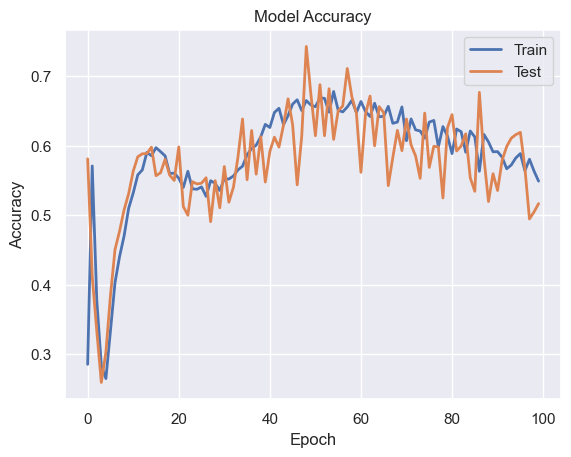

In [135]:
# Model Accuracy
plt.plot(history['accuracy'], linewidth=2, label='Train')
plt.plot(history['val_accuracy'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

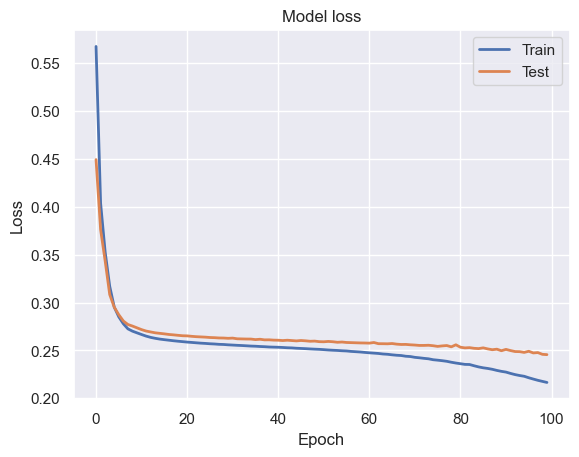

In [136]:
#Model Loss
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [137]:
#Reconstruction Error Check
# test_x_predictions = autoencoder.predict(X_test1)
# mse = np.mean(np.power(X_test1 - test_x_predictions, 2), axis=1)
# error_df = pd.DataFrame({'Reconstruction_error': mse,
#                         'True_class': y_test1})
# error_df.describe()
predictions = autoencoder.predict(X_test1)
mse = np.mean(np.power(X_test1 - predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test1})
error_df.describe()

188/188 [==============================] - 1s 2ms/step


,Reconstruction_error,True_class
count,6000.000000,6000.000000
mean,0.004444,0.218833
std,0.013188,0.413490
min,0.000087,0.000000
25%,0.000984,0.000000
50%,0.002329,0.000000
75%,0.004515,0.000000
max,0.497347,1.000000


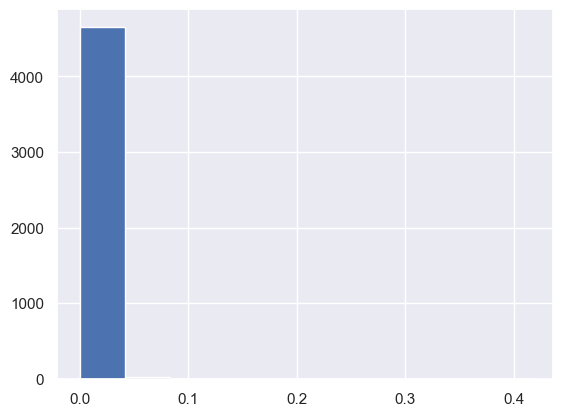

In [138]:
#Reconstruction error without default
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['True_class']== 0) & (error_df['Reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.Reconstruction_error.values, bins=10)

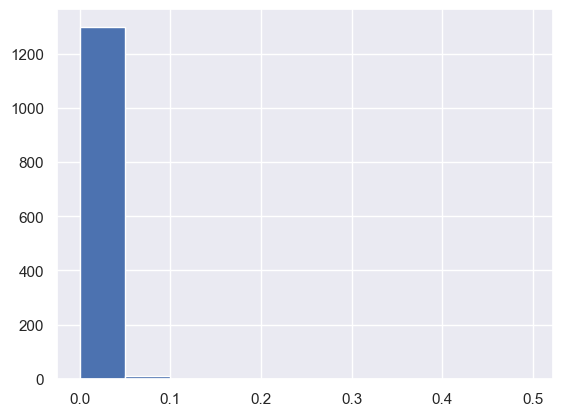

In [139]:
##Reconstruction error with default
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['True_class'] == 1]
_ = ax.hist(fraud_error_df.Reconstruction_error.values, bins=10)


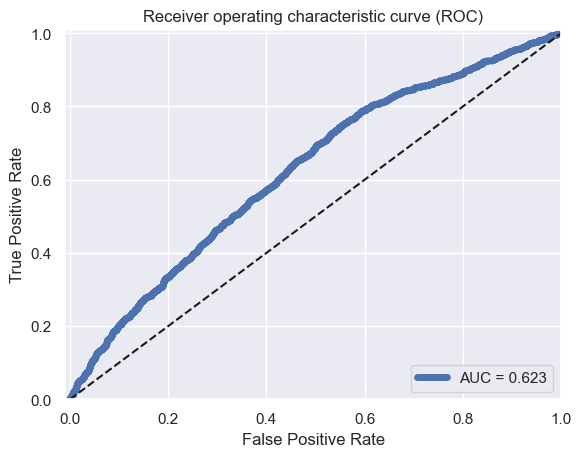

In [140]:
#ROC Curve Check
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1],'k--' )

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

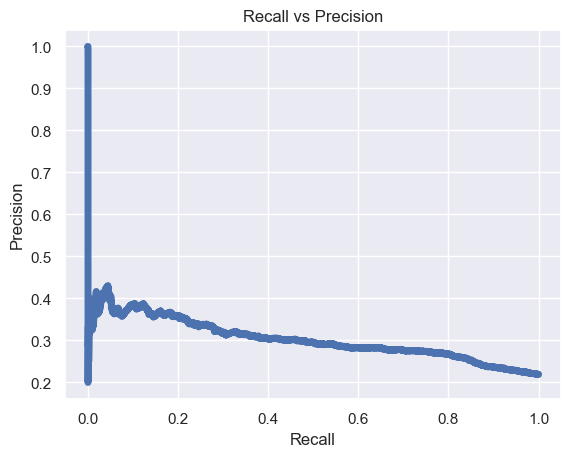

In [141]:
#Recall-v-Precision
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

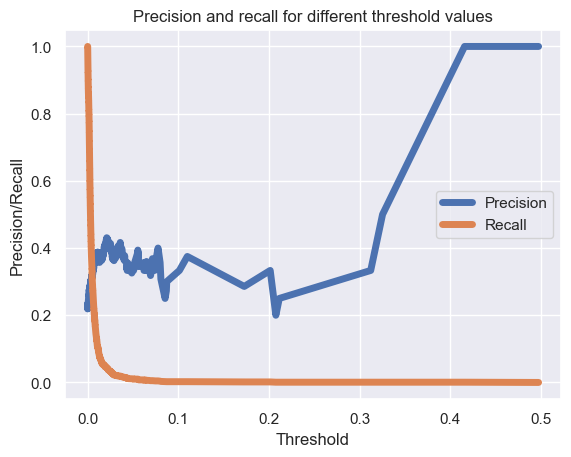

In [142]:
#precision-and-recall-tensorflow
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

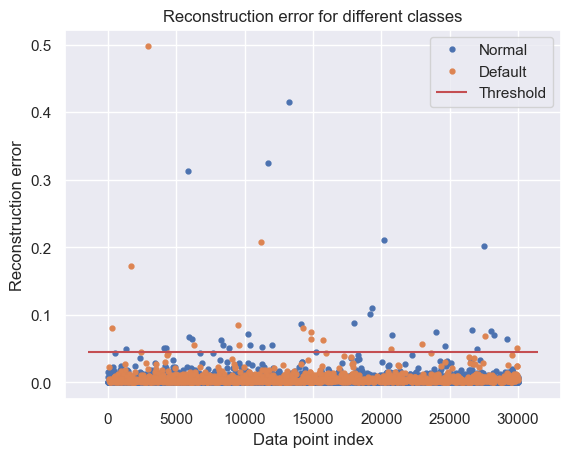

In [146]:
#Reconstruction Error vs Threshold Check
threshold_fixed = 0.045
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Default" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show(); 

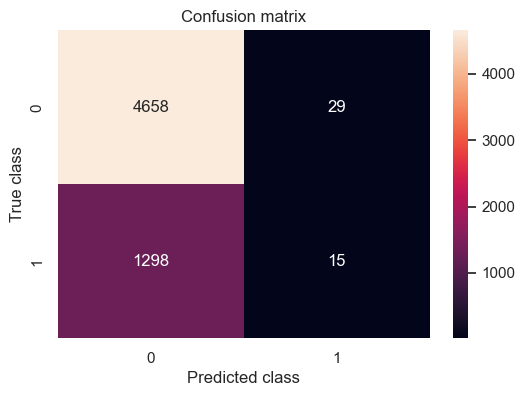

In [147]:
#Confusion Matrix
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y) #this will carryout CLASSIFICATION

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d")#, xticklabels='Predicted', yticklabels='True', annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [148]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print(classification_report(error_df.True_class, pred_y))
# DISPLAY THE VALUE FOR ACCURACY
acc = accuracy_score(error_df.True_class, pred_y)
print('Accuracy: %f' % acc)
# DISPLAY THE VALUE FOR PRECISION
precision = precision_score(error_df.True_class, pred_y)
print('Precision: %f' % precision)
# DISPLAY THE VALUE FOR RECALL
recall = recall_score(error_df.True_class, pred_y)
print('Recall: %f' % precision)

              precision    recall  f1-score   support

           0       0.78      0.99      0.88      4687
           1       0.34      0.01      0.02      1313

    accuracy                           0.78      6000
   macro avg       0.56      0.50      0.45      6000
weighted avg       0.69      0.78      0.69      6000

Accuracy: 0.778833
Precision: 0.340909
Recall: 0.340909
